# <font color='orange'>Machine Learning for Stock Index Predictions</font>
This code is an implementation of a Bachelor's thesis titled Machine Learning for Stock Index Predictions.

<br>

**Author:** Matej Šembera

**Date:** 1.2.2024

## <font color='orange'>Importing libraries and data</font>

In [1]:
# Importing essential data manipulation and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

# Libraries for acquiring financial data
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas_ta as ta

# Machine learning libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import statsmodels.api as sm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed

In [2]:
# Importing data of S&P 500 index from 15.1.2001 until 24.1.2024
sp500 = yf.download('^GSPC', period='max')
sp500_data = yf.download('^GSPC', period='max')
sp500 = sp500.loc['2001-01-15':'2024-01-24']
sp500.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-16 00:00:00-05:00,1318.319946,1327.810059,1313.329956,1326.650024,1326.650024,1205700000
2001-01-17 00:00:00-05:00,1326.650024,1346.920044,1325.410034,1329.469971,1329.469971,1349100000
2001-01-18 00:00:00-05:00,1329.890015,1352.709961,1327.410034,1347.969971,1347.969971,1445000000
2001-01-19 00:00:00-05:00,1347.969971,1354.550049,1336.739990,1342.540039,1342.540039,1407800000
2001-01-22 00:00:00-05:00,1342.540039,1353.619995,1333.839966,1342.900024,1342.900024,1164000000


In [3]:
# Changing the index format to 'YYYY-MM-DD'
sp500.index = sp500.index.strftime('%Y-%m-%d')

# Converting index to datetime format
sp500.index = pd.to_datetime(sp500.index)

# Creating a new column: close next day
sp500['Close day before'] = sp500['Close'].shift(1)

# Calculating percantage change
sp500['pct_change'] = (sp500['Close'] - sp500['Close day before'])  / sp500['Close day before'] * 100

# Defining a function to convert an integer to a boolean value
def bool_to_int(val):
    if val:
        return 1
    else:
        return 0

# Creating a Direction column where a value of 1 indicates an upward movement in the index on that day,
# while a value of 0 indicates a downward movement
sp500['Direction'] = sp500['pct_change'].apply(lambda x: bool_to_int(x>0))

sp500[-5:]

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction
Date,,,,,,,,,
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019000000,4739.209961,0.880526,1
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287200000,4780.939941,1.231350,1
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297610000,4839.810059,0.219433,1
2024-01-23,4856.799805,4866.479980,4844.370117,4864.600098,4864.600098,3912800000,4850.430176,0.292137,1
2024-01-24,4888.560059,4903.680176,4865.939941,4868.549805,4868.549805,4330030000,4864.600098,0.081193,1


## <font color='orange'>Defining functions</font>
When repeated code patterns occur frequently, it's typically more efficient to write that code into a function. By doing so, we eliminate the need to rewrite the code each time and can instead simply call the function when needed.

##### <font color='orange'>Functions for Visualizing Results</font>

In [4]:
def c_matrix(y_test, y_pred_class):
    """
    Prints a confusion matrix.
    
    Parameters:
    y_pred_class (pandas Series) : Series that contains the predicted label of each day.
    y_test (pandas Series) : Series that contains the actual label of each day.
    
    Returns:
    Confusion matrix.
    """
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [5]:
def roc(y_test, y_pred_class):
    """
    Prints a ROC curve.
    
    Parameters:
    y_pred_class (pandas Series) : Series that contains the predicted label of each day.
    y_test (pandas Series) : Series that contains the actual label of each day.
    
    Returns:
    The ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_class)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend()
    plt.show()

In [6]:
def investment_return(y_pred_class, sp500_data):
    """
    Calculates the NORD value. 
    
    Parameters:
    y_pred_class (pandas Series) : Series that contains the predicted label of each day.
    sp500_data (pandas DataFrame): Stock market data for the given time period.
    
    Returns:
    investment_returns (pandas DataFrame): DataFrame containing the cummulative NORD value over time
    and S&P 500 returns.
    """
    
    # Calculating the daily returns of the S&P 500
    sp500_returns = sp500_data['pct_change']

    # Creating a new DataFrame to track the investment performance.
    investment_returns = pd.DataFrame({'SP500': sp500_returns, 'Investment': y_pred_class * sp500_returns})
    
    # Creating new columns
    investment_returns['dollars_SP500'] = 0
    investment_returns['dollars'] = 0
    
    # Tracking the daily change in value for one dollar - cummulative NORD
    investment_returns.iloc[0, investment_returns.columns.get_loc('dollars_SP500')] = 1 + investment_returns.iloc[0]["SP500"] / 100
    for i in range(1, len(investment_returns)):
        investment_returns.iloc[i, investment_returns.columns.get_loc('dollars_SP500')] = (1 + investment_returns.iloc[i]["SP500"] / 100) * investment_returns.iloc[i - 1]["dollars_SP500"]
    
    # Same for the SP500
    investment_returns.iloc[0, investment_returns.columns.get_loc('dollars')] = 1 + investment_returns.iloc[0]["Investment"] / 100
    for i in range(1, len(investment_returns)):
        investment_returns.iloc[i, investment_returns.columns.get_loc('dollars')] = (1 + investment_returns.iloc[i]["Investment"] / 100) * investment_returns.iloc[i - 1]["dollars"]
    return investment_returns

In [7]:
def plot_investment_performance(y_pred_class, sp500_data):
    """
    This function generates a graphical comparison of our model's performance with the S&P 500.

    Parameters:
    y_pred_class (pandas Series) : Series that contains the predicted label of each day.
    sp500_data (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.

    Returns:
    Graph.
    """
    
    investment_returns = investment_return(y_pred_class, sp500_data)
    
    # Plotting the cumulative returns of the S&P 500 and the NORD
    plt.plot(investment_returns["dollars_SP500"].values, label='S&P 500')
    plt.plot(investment_returns["dollars"].values, label='Our Model')
    plt.legend()
    plt.title('Performance of our model compared to S&P 500')
    plt.xlabel('Number of Days')
    plt.ylabel('Cumulative Return')
    plt.show()

In [8]:
def plot_knn(X, y, n_neighbors=12):
    """
    Visualization of K-Nearest Neighbors algorithm. 
       
    Parameters:
    X (pandas Dataframe): DataFrame containing the values of features.
    y (array-like): Array containing the labels for each day.
    n_neighbors (int): Number of neighbors used in K-Nearest Neighbors algorithm.
    
    Returns:
    A plot with Feature 1 on the x-axis and Feature 2 on the y-axis, where each dot corresponds to a 
    specific day.The colors in the figure have the following meanings:
    • Blue dots: Data points belonging to class zero.
    • Red dots: Data points belonging to class one.
    • Light Red: Represents an area in which, if a new data point is assigned, its predicted
    class will be one.
    • Light Blue: Represent a prediction of a fall in the index S&P 500 in this area, classi-
    fying a new point as 0.
    
    The function also returns the execution time.
    """
    start_time = time.time()

    # Defining the step size for meshgrid
    h = .02

    # Creating a color map for red and blue colors
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    # Creating a KNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors)

    # Fitting the classifier on the data
    clf.fit(X, y)

    # Plotting the decision boundaries
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plotting the mesh grid
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(15, 15))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plotting the training points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Setting labels and title
    plt.xlabel('Day 1 Before')
    plt.ylabel('Day 2 Before')
    plt.title(f"kNN (k = {n_neighbors})")

    # Adding legend
    plt.legend(['Positive', 'Negative'])
    
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")

In [9]:
def plot_random_forest(X, y):
    """
    Visualization of Random Forest algorithm.
       
    Parameters:
    X (pandas Dataframe): DataFrame containing the values of features.
    y (array-like): Array containing the labels for each day.
    
    Returns:
    A plot with Feature 1 on the x-axis and Feature 2 on the y-axis, where each dot corresponds to a 
    specific day.The colors in the figure have the following meanings:
    • Blue dots: Data points belonging to class zero.
    • Red dots: Data points belonging to class one.
    • Light Red: Represents an area in which, if a new data point is assigned, its predicted
    class will be one.
    • Light Blue: Represent a prediction of a fall in the index S&P 500 in this area, classi-
    fying a new point as 0.
    
    The function also returns the execution time.
    """
    start_time = time.time()

    # Defining the step size for meshgrid
    h = .02

    # Creating a color map for red and blue colors
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    # Creating a RF classifier
    clf = RandomForestClassifier(max_depth=6, random_state=42)

    # Fitting the classifier on the data
    clf.fit(X, y)

    # Plotting the decision boundaries
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plotting the mesh
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(15, 15))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plotting the training points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Setting labels and title
    plt.xlabel('Day 1 Before')
    plt.ylabel('Day 2 Before')
    plt.title("Random forest model boundries")

    # Adding legend
    plt.legend(['Positive', 'Negative'])
    
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")

##### <font color='orange'>Algorithms</font>

In [10]:
def fit_random_forest(X, Y, threshold=0.5, depth=None, n_estimators=100):
    """
    Generates predictions of labels on the validation set by using the Random Forest algorithm.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Random Forest algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.
    depth (int): Max depth of the trees.
    n_estimators (int): Number of estimators used in the algorithm.

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The true labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in the 
    validation set.
    """
    
    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']

    # Creating a RandomForestClassifier object
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=1, min_samples_split=100)

    # Fitting the model to the training data
    model.fit(X_train, y_train)

    # Making predictions on the testing data
    y_pred_prob = model.predict_proba(X_validation)[:, 1]
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [11]:
def fit_logistic_regression(X, Y, threshold = 0.5):
    """
    Generates predictions of labels on the validation set by using Logistic regression algorithm.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Logistic regression 
    algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in the 
    validation set.
    """

    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']

    # Creating a LogisticRegression object
    X_train = sm.add_constant(X_train)
    model = sm.Logit(y_train, X_train)
    result = model.fit()

    # Making predictions on the validation data
    X_validation = sm.add_constant(X_validation)
    y_pred_prob = result.predict(X_validation)
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [12]:
def fit_knn(X, Y, threshold=0.5, n_neighbors=5):
    """
    Generates predictions of labels on the validation set by using the K-Nearest Neighbors algorithm.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our K-Nearest Neighbors
    algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.
    n_neighbors (int): Number of neighbors used in the K-Nearest Neighbors algorithm.

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 
    in the validation set.
    """ 

    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']

    # Creating a KNeighborsClassifier object
    model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Fitting the model to the training data
    model.fit(X_train, y_train)

    # Making predictions on the testing data
    y_pred_prob = model.predict_proba(X_validation)[:, 1]
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [13]:
def fit_svm(X, Y, threshold=0.5, C=1.0, kernel='rbf', gamma='scale'):
    """
    Generates predictions of labels on the validation set by using the Support Vector Classifier.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Support Vector 
    Classifier algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.
    kernel (string): Specifies the type of kernel function used in the algorithm.
    gamma (string): Parameter for the kernel, influencing the flexibility of the decision boundary 
    in the Support Vector Classifier.

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in 
    the validation set.
    """

    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']
    
    # Creating a Support Vector Machine object
    model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    # Fitting the model to the training data
    model.fit(X_train, y_train)

    # Making predictions on the testing data
    y_pred_prob = model.predict_proba(X_validation)[:, 1]
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [14]:
def fit_lstm(X, Y, threshold=0.5, n_steps=5, n_features=1):
    """
    Generates predictions of labels on the validation set by using the Long-Short Term Memory algorithm.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Long-Short Term Memory 
    algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.
    n_steps (int): Refers to the number of time steps or lag observations Long-Short Term Memory should 
    consider.
    n_features (int): Refers to the number of input features or variables used in the model.
    

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in 
    the validation set.
    """

    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']
    
    # Reshaping the input data for the Long-Short Term Memory model
    X_train = X_train.values.reshape((X_train.shape[0], n_steps, n_features))
    X_validation = X_validation.values.reshape((X_validation.shape[0], n_steps, n_features))

    # Creating an Long-Short Term Memory model
    seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_steps, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fitting the model to the training data
    model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=0)

    # Making predictions on the testing data
    y_pred_prob = model.predict(X_validation)
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [15]:
def fit_lstm_improved(X, Y, threshold=0.5, n_steps=5, n_features=1):
    """
    Generates predictions of labels on the validation set by using the Long-Short Term Memory Improved
    algorithm. Long-Short Term Memory Improved alogirthm compared to Long-Short Term Memory Improved
    algorithm has more sequences and also contains dropouts. 
    
    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Long-Short Term Memory 
    Improved algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.
    n_steps (int): Refers to the number of time steps or lag observations Long-Short Term Memory Improved
    should consider.
    n_features (int): Refers to the number of input features or variables used in the model.

    Returns:
    accuracy (float): Accuracy of our algorithm on the validation set.
    y_validation (pandas Series): The labels of each day in the validation set.
    y_pred_class (pandas Series): Predicted labels for each day in the validation set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in the 
    validation set.
    """

    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']
    
    # Applying MinMaxScaler
    sc = MinMaxScaler(feature_range=(0, 1))
    X_train = sc.fit_transform(X_train)
    X_validation = sc.transform(X_validation)

    # Reshaping the input data for the Long-Short Term Memory model
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_features))
    X_validation = X_validation.reshape((X_validation.shape[0], n_steps, n_features))

    # Creating an Long-Short Term Memory model with dropout layers
    seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fitting the model to the training data
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Making predictions on the testing data
    y_pred_prob = model.predict(X_validation)
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)

    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_validation, y_pred_class)
    return accuracy, y_validation, y_pred_class, y_pred_prob

In [16]:
def fit_logistic_regression_test_data(X, Y, threshold = 0.5):
    """
    Generates predictions of labels on the test set by using Logistic regression algorithm.

    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our Logistic regression 
    algorithm.
    Y (pandas.Series): Direction column.
    threshold (float): The threshold used by the algorithm to convert probabilities to labels.

    Returns:
    accuracy (float): Accuracy of our algorithm on the test set.
    y_validation (pandas Series): The labels of each day in the test set.
    y_pred_class (pandas Series): Predicted labels for each day in the test set.
    y_pred_prob (pandas Series): Predicted probabilities of each day belonging to label 1 in the 
    test set.
    """

    # Splitting the data chronologically
    X_train = X.loc['2003-12-03':'2021-11-22']
    X_test = X.loc['2021-11-23':'2024-1-24']
    y_train = Y.loc['2003-12-03':'2021-11-22']
    y_test = Y.loc['2021-11-23':'2024-1-24']
    
    # Creating a LogisticRegression object
    X_train = sm.add_constant(X_train)
    model = sm.Logit(y_train, X_train)
    result = model.fit()

    # Making predictions on the testing data
    X_test = sm.add_constant(X_test)
    y_pred_prob = result.predict(X_test)
    y_pred_class = np.where(y_pred_prob > threshold, 1, 0)
    
    # Calculating and returning the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred_class)
    return accuracy, y_test, y_pred_class, y_pred_prob

##### <font color='orange'>Matrices</font>

In [17]:
def treshold_matrix(X, Y, sp500_data, n_features, n_steps=1, neighbors=5, n_estimators=100, max_depth=None):
    """
    Calculates the NORD for different algorithms and thresholds on the validation set. 
    Plots the result as matrix.
    
    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our algorithms.
    Y (pandas.Series): Direction column.
    sp500_data (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    n_features (int): Refers to the number of input features or variables used in the model.
    n_steps (int): Refers to the number of time steps or lag observations Long-Short Term memory
    should consider.
    n_neighbors (int): Number of neighbors used in K-Nearest Neighbors algorithm.
    n_estimators (int): Number of estimators used in the Random Forest algorithm.
      
    Returns:
    Matrix that contains the NORD values for different algorithms and thresholds.
    The function also returns the execution time.
    """
    start_time = time.time()
    
    # Creating matrix that consists of zeros
    matrix = [[0 for j in range(8)] for i in range(7)]
    
    thresholds = [0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
    
    # Fitting the models
    [accuracy, y_test, y_pred_class, y_pred_prob1] = fit_random_forest(X, Y, threshold=0.5, depth=max_depth, n_estimators=n_estimators)
    [accuracy, y_test, y_pred_class, y_pred_prob2] = fit_logistic_regression(X, Y, threshold = 0.5)
    [accuracy, y_test, y_pred_class, y_pred_prob3] = fit_knn(X, Y, threshold=0.5, n_neighbors=neighbors)
    [accuracy, y_test, y_pred_class, y_pred_prob4] = fit_svm(X, Y, threshold=0.5, C=1.0, kernel='rbf', gamma='scale')
    [accuracy, y_test, y_pred_class, y_pred_prob5] = fit_lstm(X, Y, threshold=0.5, n_steps=n_steps, n_features=n_features)
    [accuracy, y_test, y_pred_class, y_pred_prob6] = fit_lstm(X, Y, threshold=0.5, n_steps=n_steps, n_features=n_features)
        
    # Random Forest
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob1 > i, 1, 0)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[0][j] = round(investment_returns["dollars"].iloc[-1], 2)
        matrix[6][j] = round(investment_returns["dollars_SP500"].iloc[-1], 2)
        j = j + 1
    
    # logistic regression
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob2 > i, 1, 0)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[1][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
    
    # K-Nearest Neighbors
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob3 > i, 1, 0)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[2][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
    
    # Support Vector Classifier
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob4 > i, 1, 0)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[3][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
    
    # Long-Short Term Memory
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob5 > i, 1, 0)
        investment_returns = investment_return(y_pred_class.reshape(-1), sp500_data)
        matrix[4][j] = investment_returns["dollars"].iloc[-1]
        j = j + 1
        
    # Long-Short Term Memory Improved
    j = 0
    for i in thresholds:
        y_pred_class = np.where(y_pred_prob6 > i, 1, 0)
        investment_returns = investment_return(y_pred_class.reshape(-1), sp500_data)
        matrix[5][j] = investment_returns["dollars"].iloc[-1]
        j = j + 1
    
    
    x_labels = thresholds
    y_labels = ['fit_random_forest', 'fit_logistic_regression', 'fit_knn', 'fit_svm', 'lstm', 'lstm_improved','sp500']
    plt.figure(figsize=(10, 10))
    matrix = np.around(matrix, decimals=2)
    
    # Creating heatmap using Seaborn
    sns.heatmap(matrix, cmap='coolwarm', annot=True, xticklabels=x_labels, yticklabels=y_labels)

    # Setting plot title and axis labels
    plt.title('Threshold matrix')
    plt.xlabel('Threshold')
    plt.ylabel('Model')

    # Displaying the plot
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")
    return matrix

In [18]:
# Defining intervals used in interval matrix

# Interval 1 is our whole validation set
interval1 = ('2017-9-26', "2021-11-22")

# Splitting the validation set into two subsets
# Interval 2 is first subset of the validation set
interval2 = ("2020-2-18", "2020-3-23")

# Interval 3 is second subset of the validation set
interval3 = ("2020-3-24", "2021-11-22")

In [19]:
def interval_matrix(X, Y, interval1, interval2, interval3, sp500_data, n_features, thresholds, n_steps=1, neighbors=5, n_estimators=100, max_depth=None):
    """
    Calculates the NORD for each algorithm and interval. Plots the result as matrix.
    
    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our algorithms.
    Y (pandas.Series): Direction column.
    interval1 (tuple): Train set used by algorithms.
    interval2 (tuple): Validation set used by algorithms. First subset.
    interval3 (tuple): Validation set used by algorithms. Second subset.
    sp500_data (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    n_features (int): Refers to the number of input features or variables used in the model.
    thresholds (list): A collection of threshold values used by the algorithms.
    n_steps (int): Refers to the number of time steps or lag observations Long-Short Term memory should consider.
    n_neighbors (int): Number of neighbors used in K-Nearest Neighbors algorithm.
    n_estimators (int): Number of estimators used in the algorithm.
      
    Returns:
    Matrix that contains the NORD values for different algorithms and intervals.
    The function also returns the execution time.
    """
    start_time = time.time()
    
    # Splitting the data chronologically
    X_train = X.loc[:'2017-9-25']
    X_validation = X.loc['2017-9-26':'2021-11-22']
    y_train = Y.loc[:'2017-9-25']
    y_validation = Y.loc['2017-9-26':'2021-11-22']
    
    # Fitting the models
    
    # Random Forest
    model1 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=1, min_samples_split=100)
    model1.fit(X_train, y_train)
    
    # logistic regression
    X_train1 = sm.add_constant(X_train)
    model2 = sm.Logit(y_train, X_train1)
    result = model2.fit()
    
    # K-Nearest Neighbors
    model3 = KNeighborsClassifier(n_neighbors=neighbors)
    model3.fit(X_train, y_train)
    
    # Support Vector Classifier
    model4 = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)
    model4.fit(X_train, y_train)
    
    # Long-Short Term Memory
    X_train2 = X_train.values.reshape((X_train.shape[0], n_steps, n_features))
    X_validation2 = X_validation.values.reshape((X_validation.shape[0], n_steps, n_features))
    X_validation2_df = pd.DataFrame(X_validation2.squeeze(), index=X_validation.index)
    seed(42)
    tf.random.set_seed(42)
    model5 = Sequential()
    model5.add(LSTM(50, input_shape=(n_steps, n_features)))
    model5.add(Dense(1, activation='sigmoid'))
    model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model5.fit(X_train2, y_train, epochs=50, batch_size=72, verbose=0)
    
    # Long-Short Term Memory improved
    sc = MinMaxScaler(feature_range=(0, 1))
    X_train3 = sc.fit_transform(X_train)
    X_validation3 = sc.transform(X_validation)
    X_train3 = X_train3.reshape((X_train.shape[0], n_steps, n_features))
    X_validation3 = X_validation3.reshape((X_validation.shape[0], n_steps, n_features))
    X_validation3_df = pd.DataFrame(X_validation3.squeeze(), index=X_validation.index)
    seed(42)
    tf.random.set_seed(42)
    model6 = Sequential()
    model6.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, n_features)))
    model6.add(Dropout(0.2))
    model6.add(LSTM(units=50, return_sequences=True))
    model6.add(Dropout(0.2))
    model6.add(LSTM(units=50, return_sequences=True))
    model6.add(Dropout(0.2))
    model6.add(LSTM(units=50))
    model6.add(Dropout(0.2))
    model6.add(Dense(units=1, activation='sigmoid'))
    model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model6.fit(X_train3, y_train, epochs=100, batch_size=32, verbose=0)
    
    matrix = [[0 for j in range(3)] for i in range(7)]
    
    intervals = [interval1, interval2, interval3]
    
    # Calculating each investment return for each interval
    
    # Random Forest
    j = 0
    for interval in intervals:
        y_pred_prob = model1.predict_proba(X_validation.loc[interval[0]:interval[1]])[:,1]
        y_pred_class = np.where(y_pred_prob > thresholds[0], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class, sp500_data_interval)
        matrix[0][j] = round(investment_returns["dollars"].iloc[-1], 2)
        matrix[6][j] = round(investment_returns["dollars_SP500"].iloc[-1], 2)
        j = j + 1
        
    # K-Nearest Neighbors
    j = 0
    for interval in intervals:
        y_pred_prob = model3.predict_proba(X_validation.loc[interval[0]:interval[1]])[:, 1]
        y_pred_class = np.where(y_pred_prob > thresholds[2], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class, sp500_data_interval)
        matrix[2][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
        
    # Support Vector Classifier   
    j = 0
    for interval in intervals:
        y_pred_prob = model4.predict_proba(X_validation.loc[interval[0]:interval[1]])[:, 1]
        y_pred_class = np.where(y_pred_prob > thresholds[3], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class, sp500_data_interval)
        matrix[3][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
    
    # Logistic regression
    j = 0
    for interval in intervals:
        X_validation1 = sm.add_constant(X_validation.loc[interval[0]:interval[1]])
        y_pred_prob = result.predict(X_validation1)
        y_pred_class = np.where(y_pred_prob > thresholds[1], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class, sp500_data_interval)
        matrix[1][j] = round(investment_returns["dollars"].iloc[-1], 2)
        j = j + 1
    
    # Long-Short Term Memory
    j = 0
    for interval in intervals:
        X_validation2_reshaped = X_validation2_df.loc[interval[0]:interval[1]].values.reshape(-1, n_steps, n_features)
        y_pred_prob = model5.predict(X_validation2_reshaped)
        y_pred_class = np.where(y_pred_prob > thresholds[4], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class.reshape(-1), sp500_data_interval)
        matrix[4][j] = investment_returns["dollars"].iloc[-1]
        j = j + 1
    
    # Long-Short Term Memory Improved
    j = 0
    for interval in intervals:
        X_validation3_reshaped = X_validation3_df.loc[interval[0]:interval[1]].values.reshape(-1, n_steps, n_features)
        y_pred_prob = model6.predict(X_validation3_reshaped)
        y_pred_class = np.where(y_pred_prob > thresholds[5], 1, 0)
        sp500_data_interval = sp500_data.loc[interval[0]:interval[1]]
        investment_returns = investment_return(y_pred_class.reshape(-1), sp500_data_interval)
        matrix[5][j] = investment_returns["dollars"].iloc[-1]
        j = j + 1
    
    x_labels = intervals
    y_labels = ['fit_random_forest', 'fit_logistic_regression', 'fit_knn', 'fit_svm', 'lstm', 'lstm_improved', 'SP500']
    plt.figure(figsize=(10, 10))
    matrix = np.around(matrix, decimals=2)
    
    # Creating heatmap using Seaborn
    sns.heatmap(matrix, cmap='coolwarm', annot=True, xticklabels=x_labels, yticklabels=y_labels)

    # Setting plot title and axis labels
    plt.title('Interval matrix')
    plt.xlabel('Intervals')
    plt.ylabel('Model')

    # Displaying the plot
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")
    return matrix

##### <font color='orange'>Hyperparameter tunning</font>

In [20]:
def knn_hyper(X, Y, sp500_data):
    """
    Calculates and vizulizes the NORD values of K-Nearest Neighbors algorithm for different parameters. 
    
    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our algorithms.
    Y (pandas.Series): Direction column.
    sp500_data (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    
    Returns:
    Matrix containing NORD values for various parameters of the K-Nearest Neighbors algorithm.
    The function also returns the execution time.
    """
    start_time = time.time()
    matrix = [[0 for j in range(20)] for i in range(2)]
    neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 30, 50]
    
    # Calculating NORD for different neighbors
    # Threshold equals 0.5
    i = 0
    for neighbor in neighbors:
        [accuracy, y_test, y_pred_class, y_pred_prob] = fit_knn(X, Y, threshold=0.5, n_neighbors=neighbor)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[0][i] = round(investment_returns['dollars'].iloc[-1], 2)
        i = i + 1
        
    # Calculating NORD for different neighbors
    # Threshold equals 0.4
    i = 0
    for neighbor in neighbors:
        [accuracy, y_test, y_pred_class, y_pred_prob] = fit_knn(X, Y, threshold=0.4, n_neighbors=neighbor)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[1][i] = round(investment_returns['dollars'].iloc[-1], 2)
        i = i + 1
    
    
    plt.figure(figsize=(15, 3))
    matrix = np.round(matrix, decimals=2)
    
    # Creating heatmap using Seaborn
    sns.heatmap(matrix, cmap='coolwarm', annot=True, yticklabels= [0.5, 0.4], xticklabels=neighbors)

    # Setting plot title and axis labels
    plt.title('KNN Hyperparameter tunning')
    plt.xlabel('Neighbors')
    plt.ylabel('Thresholds')

    # Displaying the plot
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")
    return matrix

In [21]:
def hypertune_random_forest(X, Y, sp500_data):
    """
    Calculates and vizulizes the NORD values of the Random Forest algorithm for different parameters. 
    
    Parameters:
    X (pandas.DataFrame): DataFrame containing the values of features used in our algorithms.
    Y (pandas.Series): Direction column.
    sp500_data (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    
    Returns:
    Matrix containing NORD values for various parameters of the RF algorithm.
    The function also returns the execution time.
    """
    start_time = time.time()
    matrix = [[0 for j in range(7)] for i in range(2)]
    n_estimators = [3, 5, 10, 50, 100, 150, 200]
    max_debths = [1, 3, 5, 10, 20, 40, 80]
    
    # Calculating NORD for different estimators
    i = 0
    for n_estimator in n_estimators:
        [accuracy, y_test, y_pred_class, y_pred_prob] = fit_random_forest(X, Y, threshold=0.4, n_estimators=n_estimator)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[0][i] = round(investment_returns['dollars'].iloc[-1], 2)
        i = i + 1
        
    # Calculating NORD for different debths
    i = 0
    for max_debth in max_debths:
        [accuracy, y_test, y_pred_class, y_pred_prob] = fit_random_forest(X, Y, threshold=0.4,depth=max_debth)
        investment_returns = investment_return(y_pred_class, sp500_data)
        matrix[1][i] = round(investment_returns['dollars'].iloc[-1], 2)
        i = i + 1
    
    
    plt.figure(figsize=(15, 3))
    matrix = np.round(matrix, decimals=2)
    
    # Creating heatmap using Seaborn
    sns.heatmap(matrix, cmap='coolwarm', annot=True, yticklabels=['n_estimators', 'max_depth'])

    # Setting plot title and axis labels
    plt.title('Random Forest Hyperparameter tunning')

    # Displaying the plot
    plt.show()
    print("n_estimators:", n_estimators)
    print("max_debths:", max_debths)
    
    end_time = time.time()
    elapsed_time = end_time - start_time    
    print(f"The code took {elapsed_time:.5f} seconds to run.")
    return matrix

##### <font color='orange'>Feature selections</font>

In [22]:
def methodology_A(fixed_features, features, dataframe, NORD_max = 0):
    """
    Applies feature selection methodology A for the given features.
    
    Parameters:
    fixed_features (list): List of features that will remain fixed in each iteration.
    features (list): List of features used by Logistic regression.
    dataframe (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    NORD_max (float): The initial NORD_max used in the methodology A.
    
    Returns:
    A table containg NORD value for each list of features.
    """
    # Generating matrix
    matrix = [[0 for i in range(2)] for i in range(len(features))]
    best_features = []
    
    # Calculating the NORD for each list of features. Logistic regression was used to generate predictions.
    for i in range(len(features)):
        if fixed_features is not None:
            current_features = fixed_features + best_features + [features[i]]
        else:
            current_features = best_features + [features[i]]
        # Defining the training set and validation set.
        X = dataframe[current_features]
        Y = dataframe['Direction']
        X_train = X.loc[:'2017-9-25']
        X_validation = X.loc['2017-9-26':'2021-11-22']
        y_train = Y.loc[:'2017-9-25']
        y_validation = Y.loc['2017-9-26':'2021-11-22']
        X_train = sm.add_constant(X_train)
        X_validation = sm.add_constant(X_validation)
        # Trianing Logistic regression
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train, y_train)
        val_pred = model.predict(X_validation)
        # Calculating the NORD value from the predicitions generated by Logistic regression.
        NORD = investment_return(val_pred, dataframe['2017-09-26':'2021-11-22'])["dollars"].iloc[-1]
        matrix[i][0]= current_features
        matrix[i][1]= NORD
        if NORD > NORD_max:
            NORD_max = NORD
            best_features.append(features[i])
    results_df = pd.DataFrame(matrix, columns=['Features', 'NORD'])
    results = results_df.style.set_properties(subset=['Features'], **{'width':'300xp'})
    return results

In [23]:
def best_features(features, dataframe):
    """
    Calculates the NORD for each list of features.
    
    Parameters:
    features (List[Lists]): List of lists containing features used by Logistic Regression.
    dataframe (pandas.DataFrame): A DataFrame containing the daily prices of the S&P 500.
    NORD_max (float): The initial NORD_max used in the methodology A.
    
    Returns:
    A table containg NORD value for each list of features.
    """
    # Generating matrix
    matrix = [[0 for i in range(2)] for i in range(len(features))]
    results = []
    
    # Calculating the NORD for each list of features. Logistic regression was used to generate predictions.
    for i in range(len(features)):
        # Defining the training set and validation set.
        X = dataframe[features[i]]
        Y = dataframe['Direction']
        X_train = X.loc[:'2017-9-25']
        X_validation = X.loc['2017-9-26':'2021-11-22']
        y_train = Y.loc[:'2017-9-25']
        y_validation = Y.loc['2017-9-26':'2021-11-22']
        X_train = sm.add_constant(X_train)
        X_validation = sm.add_constant(X_validation)
        # Trianing Logistic regression
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train, y_train)
        val_pred = model.predict(X_validation)
        val_return = investment_return(val_pred, dataframe['2017-9-26':'2021-11-22'])["dollars"].iloc[-1]
        matrix[i][0]= features[i]
        matrix[i][1]= val_return
        
    results_df = pd.DataFrame(matrix, columns=['Features', 'NORD'])
    results_2 = results_df.style.set_properties(subset=['Features'], **{'width':'300xp'})
    return results_2

In the subsequent sections, we select features for our model, with each section representing a distinct feature group. The algorithms within each feature group are trained on different intervals. To enhance code clarity, a summary is provided at the end of each feature group.

For the Random Forest and K-Nearest Neighbors algorithms, we choose the parameters that result in the highest NORD value. Similarly, for each algorithm, we choose the threshold with the highest NORD value.

## <font color='orange'>Prior Day Percentage Changes</font>


In [24]:
# Calculating the daily percantage change of i days before
for i in range(1, 10):
    sp500['Day_' + str(i) + '_before'] = sp500['pct_change'].shift(i)
sp500.head(5)

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,Day_2_before,Day_3_before,Day_4_before,Day_5_before,Day_6_before,Day_7_before,Day_8_before,Day_9_before
Date,,,,,,,,,,,,,,,,,,
2001-01-16,1318.319946,1327.810059,1313.329956,1326.650024,1326.650024,1205700000,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-17,1326.650024,1346.920044,1325.410034,1329.469971,1329.469971,1349100000,1326.650024,0.212561,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-18,1329.890015,1352.709961,1327.410034,1347.969971,1347.969971,1445000000,1329.469971,1.391532,1,0.212561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-19,1347.969971,1354.550049,1336.739990,1342.540039,1342.540039,1407800000,1347.969971,-0.402823,0,1.391532,0.212561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-22,1342.540039,1353.619995,1333.839966,1342.900024,1342.900024,1164000000,1342.540039,0.026814,1,-0.402823,1.391532,0.212561,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Cutting off the test set to ensure unbiased evaluation
sp500_2 = sp500.loc['2001-01-30':"2021-11-22"]
sp500_2

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,Day_2_before,Day_3_before,Day_4_before,Day_5_before,Day_6_before,Day_7_before,Day_8_before,Day_9_before
Date,,,,,,,,,,,,,,,,,,
2001-01-30,1364.170044,1375.680054,1356.199951,1373.729980,1373.729980,1149800000,1364.170044,0.700788,1,0.680475,-0.188585,-0.497694,0.286682,1.303150,0.026814,-0.402823,1.391532,0.212561
2001-01-31,1373.729980,1383.369995,1364.660034,1366.010010,1366.010010,1295300000,1373.729980,-0.561971,0,0.700788,0.680475,-0.188585,-0.497694,0.286682,1.303150,0.026814,-0.402823,1.391532
2001-02-01,1366.010010,1373.500000,1359.339966,1373.469971,1373.469971,1118800000,1366.010010,0.546113,1,-0.561971,0.700788,0.680475,-0.188585,-0.497694,0.286682,1.303150,0.026814,-0.402823
2001-02-02,1373.469971,1376.380005,1348.719971,1349.469971,1349.469971,1048400000,1373.469971,-1.747399,0,0.546113,-0.561971,0.700788,0.680475,-0.188585,-0.497694,0.286682,1.303150,0.026814
2001-02-05,1349.469971,1354.560059,1344.479980,1354.310059,1354.310059,1013000000,1349.469971,0.358666,1,-1.747399,0.546113,-0.561971,0.700788,0.680475,-0.188585,-0.497694,0.286682,1.303150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,4679.419922,4714.950195,4679.419922,4700.899902,4700.899902,3972640000,4682.799805,0.386523,1,-0.001074,0.722266,0.055094,-0.822582,-0.349878,0.088779,0.373280,0.418194,0.646128
2021-11-17,4701.500000,4701.500000,4684.410156,4688.669922,4688.669922,3969070000,4700.899902,-0.260163,0,0.386523,-0.001074,0.722266,0.055094,-0.822582,-0.349878,0.088779,0.373280,0.418194
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,4704.540039,4226410000,4688.669922,0.338478,1,-0.260163,0.386523,-0.001074,0.722266,0.055094,-0.822582,-0.349878,0.088779,0.373280


In [26]:
# Calculating NORD for the Buy and Hold strategy
# Array of predictions: In the Buy and Hold strategy, each prediction is set to one.
# The interval ["2017-9-26":'2021-11-22'] has a length of 1048.
y_pred_class_buy_and_hold = np.ones(1048)
val_return_buy_and_hold = investment_return(y_pred_class_buy_and_hold, sp500_2["2017-9-26":'2021-11-22'])["dollars"].iloc[-1]
val_return_buy_and_hold

1.8756819535944504

In [27]:
# Using methodology A for feature selection.
features_percentage_changes = ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Day_4_before', 'Day_5_before', 
'Day_6_before', 'Day_7_before', 'Day_8_before', 'Day_9_before']
# Since no features are selected prior to this point, the initial value of NORD_max is NORD - BUY AND HOLD
# No fixed features are specified for repetition in each iteration.
result_percentage_changes = methodology_A(None, features_percentage_changes, sp500_2, val_return_buy_and_hold)
result_percentage_changes

,Features,NORD
0,['Day_1_before'],2.814990
1,"['Day_1_before', 'Day_2_before']",2.663071
2,"['Day_1_before', 'Day_3_before']",2.624178
3,"['Day_1_before', 'Day_4_before']",2.864749
4,"['Day_1_before', 'Day_4_before', 'Day_5_before']",3.240105
5,"['Day_1_before', 'Day_4_before', 'Day_5_before', 'Day_6_before']",3.138058
6,"['Day_1_before', 'Day_4_before', 'Day_5_before', 'Day_7_before']",1.839877
7,"['Day_1_before', 'Day_4_before', 'Day_5_before', 'Day_8_before']",2.807941
8,"['Day_1_before', 'Day_4_before', 'Day_5_before', 'Day_9_before']",2.805656


Methodology A identifies features Day_1_before, Day_4_before, and Day_5_before as important. The NORD value for the model with the feature Day_1_before is 2.81, exceeding the threshold of 1.88. Therefore, Methodology A classifies the feature Day_1_before as important. Our next step involves applying Methodology B to further refine the selection of important features.

In [28]:
# Round 1 of methodology B
features_round_1_percentage_changes = ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Day_4_before', 'Day_5_before', 
             'Day_6_before', 'Day_7_before', 'Day_8_before', 'Day_9_before']
result_round_1_percentage_changes = best_features(features_round_1_percentage_changes, sp500_2)
result_round_1_percentage_changes 

,Features,NORD
0,Day_1_before,2.814990
1,Day_2_before,1.875682
2,Day_3_before,1.946424
3,Day_4_before,1.806351
4,Day_5_before,1.728185
5,Day_6_before,1.714787
6,Day_7_before,1.361456
7,Day_8_before,1.765490
8,Day_9_before,1.649480


In [29]:
# Round 2 of methodology B
features_round_2_percentage_changes  = [
    ['Day_1_before', 'Day_2_before'],
    ['Day_1_before', 'Day_3_before'],
    ['Day_1_before', 'Day_4_before'],
    ['Day_1_before', 'Day_5_before'],
    ['Day_1_before', 'Day_6_before'],
    ['Day_1_before', 'Day_7_before'],
    ['Day_1_before', 'Day_8_before'],
    ['Day_1_before', 'Day_9_before']
]
result_round_2_percentage_changes  = best_features(features_round_2_percentage_changes , sp500_2)
result_round_2_percentage_changes 

,Features,NORD
0,"['Day_1_before', 'Day_2_before']",2.663071
1,"['Day_1_before', 'Day_3_before']",2.624178
2,"['Day_1_before', 'Day_4_before']",2.864749
3,"['Day_1_before', 'Day_5_before']",3.046028
4,"['Day_1_before', 'Day_6_before']",2.510799
5,"['Day_1_before', 'Day_7_before']",2.228203
6,"['Day_1_before', 'Day_8_before']",2.489706
7,"['Day_1_before', 'Day_9_before']",2.531701


In [30]:
# Round 3 of methodology B
features_round_3_percentage_changes = [
    ['Day_1_before', 'Day_5_before', 'Day_2_before'],
    ['Day_1_before', 'Day_5_before', 'Day_3_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before'],
    ['Day_1_before', 'Day_5_before', 'Day_6_before'],
    ['Day_1_before', 'Day_5_before', 'Day_7_before'],
    ['Day_1_before', 'Day_5_before', 'Day_8_before'],
    ['Day_1_before', 'Day_5_before', 'Day_9_before'],
]
result_round_3_percentage_changes  = best_features(features_round_3_percentage_changes, sp500_2)
result_round_3_percentage_changes 

,Features,NORD
0,"['Day_1_before', 'Day_5_before', 'Day_2_before']",2.836552
1,"['Day_1_before', 'Day_5_before', 'Day_3_before']",2.760464
2,"['Day_1_before', 'Day_5_before', 'Day_4_before']",3.240105
3,"['Day_1_before', 'Day_5_before', 'Day_6_before']",2.736001
4,"['Day_1_before', 'Day_5_before', 'Day_7_before']",1.918730
5,"['Day_1_before', 'Day_5_before', 'Day_8_before']",2.566176
6,"['Day_1_before', 'Day_5_before', 'Day_9_before']",2.574976


In [31]:
# Rround 4 of methodology B
features_round_4_percentage_changes = [
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_2_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_3_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_6_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_7_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_8_before'],
    ['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_9_before']
]
result_round_4_percentage_changes = best_features(features_round_4_percentage_changes, sp500_2)
result_round_4_percentage_changes

,Features,NORD
0,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_2_before']",3.190184
1,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_3_before']",2.851312
2,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_6_before']",3.138058
3,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_7_before']",1.839877
4,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_8_before']",2.807941
5,"['Day_1_before', 'Day_5_before', 'Day_4_before', 'Day_9_before']",2.805656


According to methodology B, the best combination of features consists of Day_1_before and Day_5_before. However, both methodologies skip Day_2_before and Day_3_before before including Day_4_before. To address this, we adopt an alternative approach: systematically add features one by one until we establish a cutoff point.

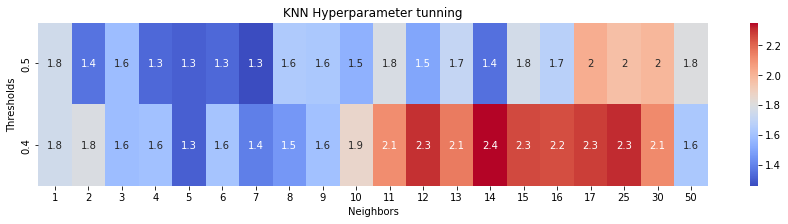

The code took 22.20946 seconds to run.


In [32]:
# Selecting Day_1_before as a feature
Features_D1B = sp500_2['Day_1_before']
Y = sp500_2['Direction']

Features_D1B = np.array(Features_D1B).reshape(-1, 1)
Features_D1B_df = pd.DataFrame(Features_D1B, columns=['feature'], index=Y.index)

# Selecting the right parameters for KNN
matrix_knn_parameters_percentage_changes = knn_hyper(Features_D1B_df, Y, sp500_2['2017-9-26':])

In [33]:
matrix_knn_parameters_percentage_changes

array([[1.75, 1.36, 1.58, 1.33, 1.31, 1.33, 1.26, 1.64, 1.63, 1.54, 1.78,
        1.5 , 1.71, 1.35, 1.76, 1.67, 2.02, 1.96, 1.99, 1.8 ],
       [1.75, 1.79, 1.58, 1.6 , 1.31, 1.61, 1.39, 1.46, 1.6 , 1.86, 2.11,
        2.3 , 2.15, 2.35, 2.26, 2.25, 2.28, 2.31, 2.12, 1.63]])

The parameter combination of 14 neighbors with a threshold of 0.4 results in the highest NORD.

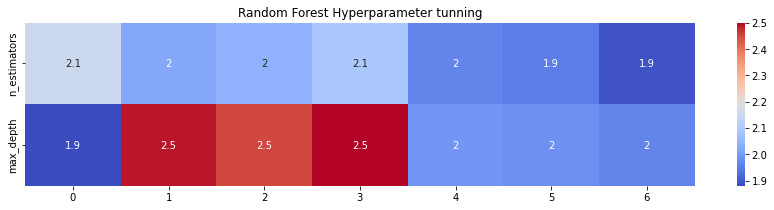

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 13.03370 seconds to run.


In [34]:
# Selecting the right parameters for RF
matrix_rf_parameters_percentage_changes = hypertune_random_forest(Features_D1B_df, Y, sp500_2['2017-9-26':])

In [35]:
matrix_rf_parameters_percentage_changes

array([[2.15, 2.02, 2.04, 2.09, 1.96, 1.95, 1.89],
       [1.88, 2.49, 2.45, 2.5 , 1.99, 1.98, 1.96]])

A max depth of 10 and n_estimators of 3 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.689174
         Iterations 4
33/33 [==============================] - 0s 1ms/step


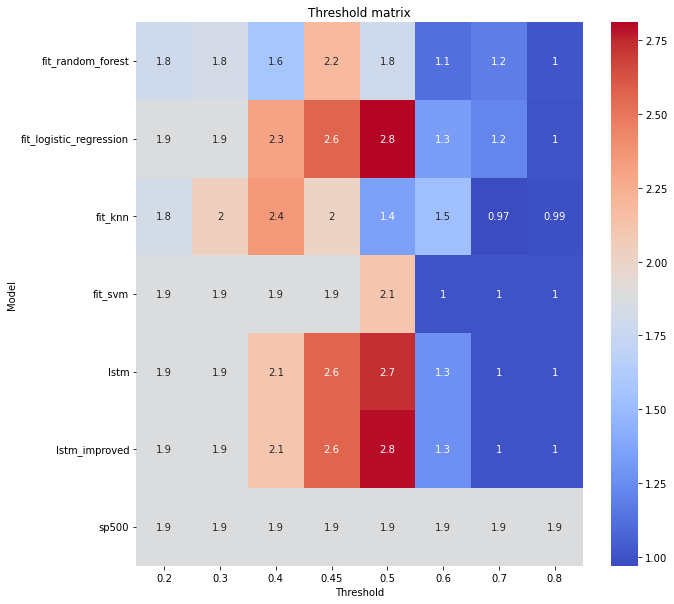

The code took 51.94077 seconds to run.


In [36]:
matrix_D1B_threshold = treshold_matrix(Features_D1B_df, Y, sp500_2["2017-9-26":], 1, n_steps=1, n_estimators=3, max_depth=10, neighbors=14)

In [37]:
matrix_D1B_threshold

array([[1.79, 1.83, 1.57, 2.18, 1.79, 1.12, 1.18, 1.01],
       [1.88, 1.88, 2.3 , 2.56, 2.81, 1.33, 1.22, 1.  ],
       [1.82, 2.04, 2.35, 2.  , 1.35, 1.53, 0.97, 0.99],
       [1.88, 1.88, 1.88, 1.88, 2.11, 1.  , 1.  , 1.  ],
       [1.88, 1.88, 2.11, 2.56, 2.73, 1.27, 1.  , 1.  ],
       [1.88, 1.88, 2.11, 2.56, 2.79, 1.27, 1.  , 1.  ],
       [1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88]])

The thresholds 0.45, 0.5, 0.4, 0.5, 0.5, 0.5, corresponding to the algorithms Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Long-Short Term Memory, and Long-Short Term Memory Improved, respectively, yield the highest NORD.

In [38]:
thresholds_D1B = [0.45, 0.5, 0.4, 0.5, 0.5, 0.5]

Optimization terminated successfully.
         Current function value: 0.689174
         Iterations 4
14/14 [==============================] - 0s 1ms/step


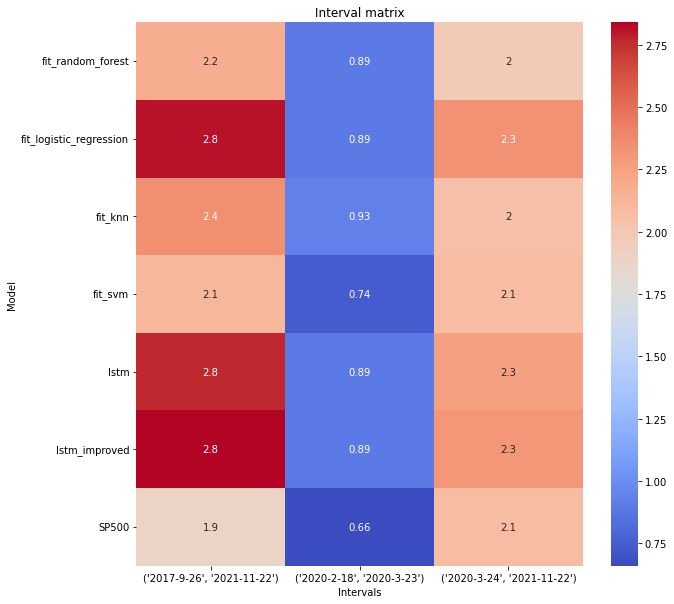

The code took 101.90484 seconds to run.


In [39]:
matrix_D1B_interval = interval_matrix(Features_D1B_df, Y, interval1, interval2, interval3, sp500_2["2017-9-26":], 1, thresholds_D1B, neighbors=14, n_estimators=3, max_depth=10)

In [40]:
matrix_D1B_interval

array([[2.18, 0.89, 1.97],
       [2.81, 0.89, 2.33],
       [2.35, 0.93, 2.05],
       [2.12, 0.74, 2.09],
       [2.77, 0.89, 2.26],
       [2.84, 0.89, 2.31],
       [1.88, 0.66, 2.09]])

In [41]:
# Selecting Day_1_before, Day_2_before as our features
Features_D1B_D2B = sp500_2[['Day_1_before', 'Day_2_before']]

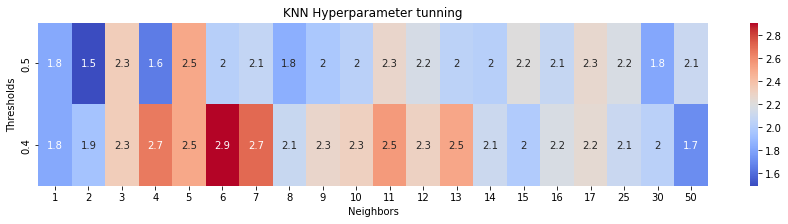

The code took 21.56551 seconds to run.


In [42]:
# Selecting the right parameters for KNN
matrix_knn_parameters_percentage_changes_D1B_D2B = knn_hyper(Features_D1B_D2B, Y, sp500_2['2017-9-26':])

In [43]:
matrix_knn_parameters_percentage_changes_D1B_D2B

array([[1.82, 1.49, 2.33, 1.65, 2.5 , 2.02, 2.07, 1.84, 1.97, 2.03, 2.27,
        2.16, 2.04, 2.02, 2.2 , 2.08, 2.26, 2.17, 1.81, 2.1 ],
       [1.82, 1.94, 2.33, 2.66, 2.5 , 2.91, 2.71, 2.09, 2.27, 2.31, 2.55,
        2.3 , 2.51, 2.11, 1.99, 2.17, 2.24, 2.1 , 2.03, 1.71]])

The parameter combination of 6 neighbors with a threshold of 0.4 results in the highest NORD.

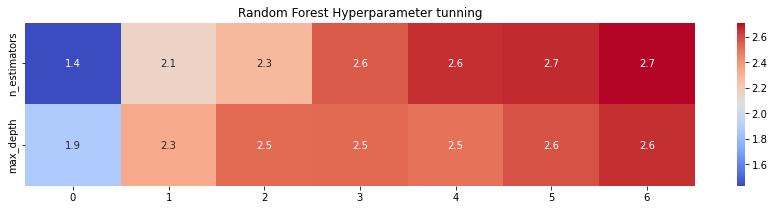

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 11.81645 seconds to run.


In [44]:
# Selecting the right parameters for RF
matrix_rf_parameters_percentage_changes_D1B_D2B = hypertune_random_forest(Features_D1B_D2B, Y, sp500_2['2017-9-26':])

In [45]:
matrix_rf_parameters_percentage_changes_D1B_D2B

array([[1.43, 2.15, 2.28, 2.56, 2.65, 2.66, 2.71],
       [1.88, 2.34, 2.52, 2.53, 2.5 , 2.58, 2.65]])

A max depth of 80 and n_estimators of 200 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4
33/33 [==============================] - 1s 1ms/step


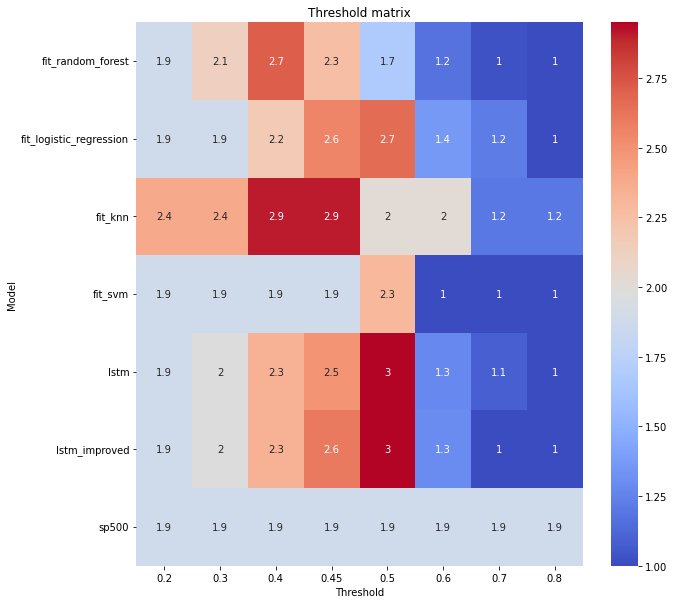

The code took 49.85473 seconds to run.


In [46]:
matrix_D1B_D2B_threshold = treshold_matrix(Features_D1B_D2B, Y, sp500_2["2017-9-26":], 2, n_steps=1, n_estimators=200, max_depth=80, neighbors=6)

In [47]:
matrix_D1B_D2B_threshold

array([[1.88, 2.13, 2.71, 2.26, 1.68, 1.17, 1.03, 1.  ],
       [1.88, 1.88, 2.18, 2.56, 2.66, 1.36, 1.22, 1.  ],
       [2.38, 2.38, 2.91, 2.91, 2.02, 2.02, 1.2 , 1.2 ],
       [1.88, 1.88, 1.88, 1.88, 2.3 , 1.  , 1.  , 1.  ],
       [1.88, 1.98, 2.34, 2.49, 2.95, 1.28, 1.09, 1.  ],
       [1.88, 1.98, 2.34, 2.6 , 2.95, 1.29, 1.  , 1.  ],
       [1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88]])

The thresholds 0.4, 0.5, 0.45, 0.5, 0.5, 0.5, corresponding to the algorithms Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Long-Short Term Memory, and Long-Short Term Memory Improved, respectively, yield the highest NORD.

In [48]:
thresholds_D1B_D2B = [0.4, 0.5, 0.45, 0.5, 0.5, 0.5]

Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4
14/14 [==============================] - 0s 2ms/step


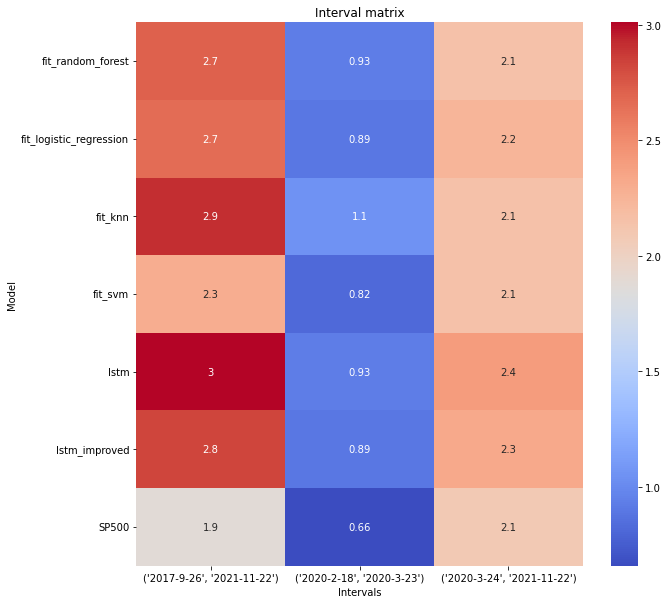

The code took 94.36026 seconds to run.


In [49]:
matrix_D1B_D2B_interval = interval_matrix(Features_D1B_D2B, Y, interval1, interval2, interval3, sp500_2["2017-9-26":], 2, thresholds_D1B_D2B, neighbors=6, n_estimators=200, max_depth=80)

In [50]:
matrix_D1B_D2B_interval

array([[2.71, 0.93, 2.15],
       [2.66, 0.89, 2.24],
       [2.91, 1.05, 2.15],
       [2.3 , 0.82, 2.15],
       [3.01, 0.93, 2.41],
       [2.83, 0.89, 2.33],
       [1.88, 0.66, 2.09]])

In [51]:
# Calculating the difference in NORD between interval matrices to identify which algorithms on 
# specific intervals have shown improvement.
print(matrix_D1B_D2B_interval - matrix_D1B_interval)

[[ 0.53  0.04  0.18]
 [-0.15  0.   -0.09]
 [ 0.56  0.12  0.1 ]
 [ 0.18  0.08  0.06]
 [ 0.24  0.04  0.15]
 [-0.01  0.    0.02]
 [ 0.    0.    0.  ]]


C:\Users\sembm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


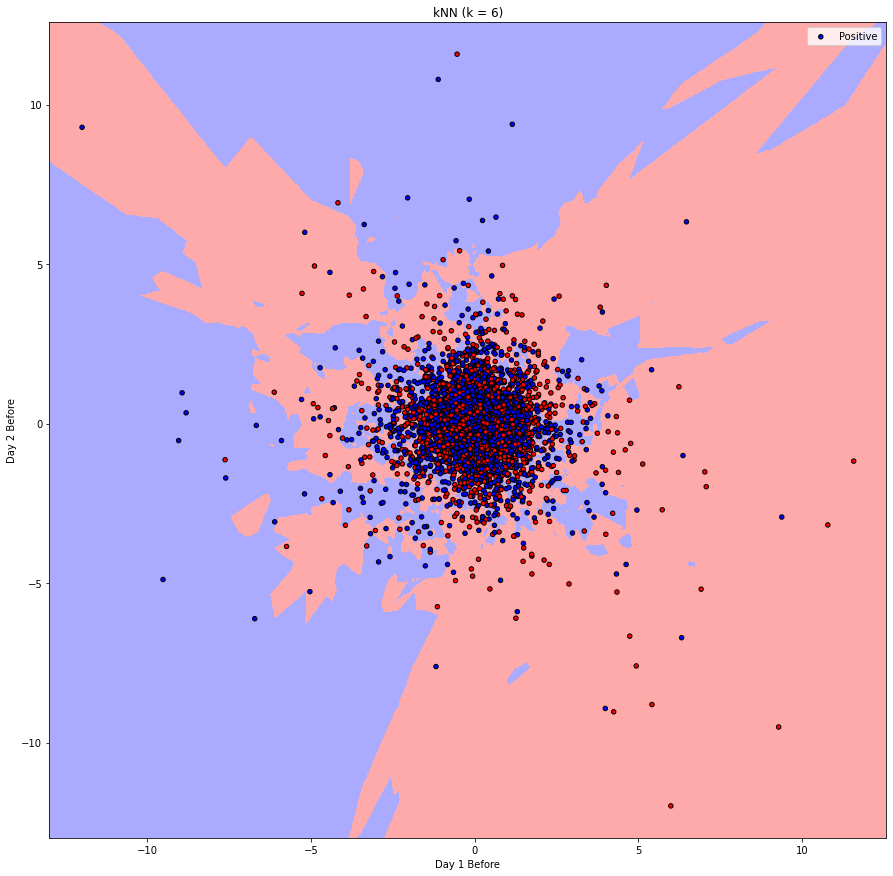

The code took 75.40009 seconds to run.


In [52]:
# Visualizing the K-Nearest-Neighbors algorithm
plot_knn(Features_D1B_D2B, Y, n_neighbors=6)

In [53]:
plt.savefig('plot_knn_neighbors_6.svg', format='svg')

<Figure size 432x288 with 0 Axes>

C:\Users\sembm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


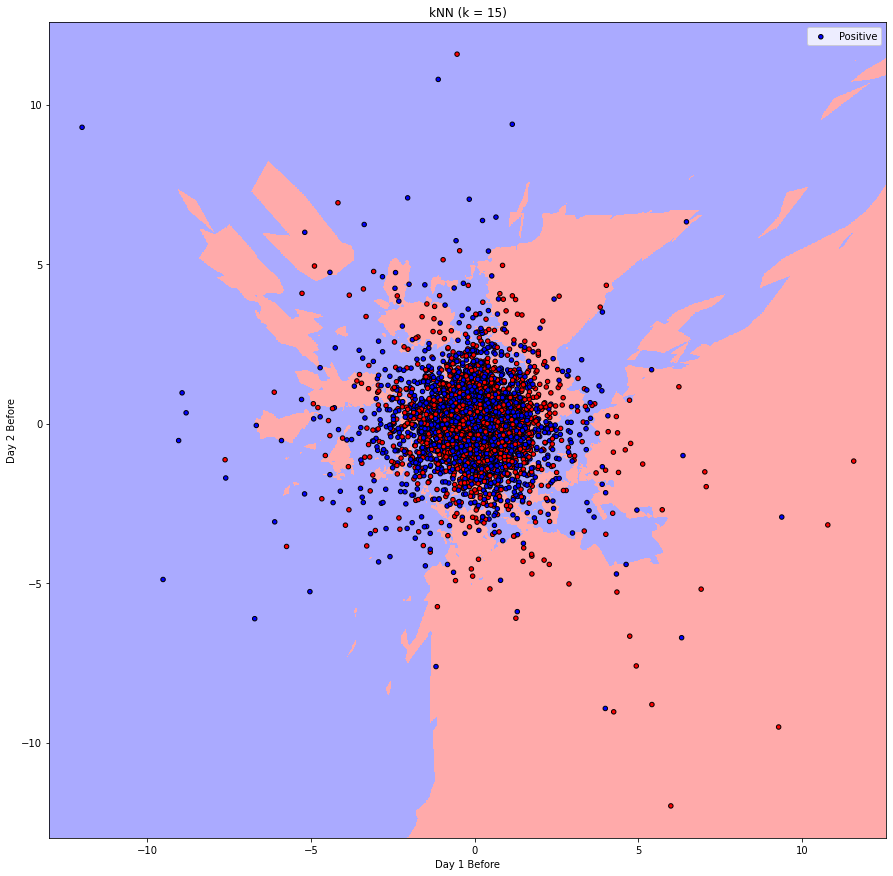

The code took 99.15543 seconds to run.


In [54]:
# Visualizing the K-Nearest-Neighbors algorithm with different number of neighbors
plot_knn(Features_D1B_D2B, Y, n_neighbors=15)

In [55]:
plt.savefig('plot_knn_neighbors_15.svg', format='svg')

<Figure size 432x288 with 0 Axes>

C:\Users\sembm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


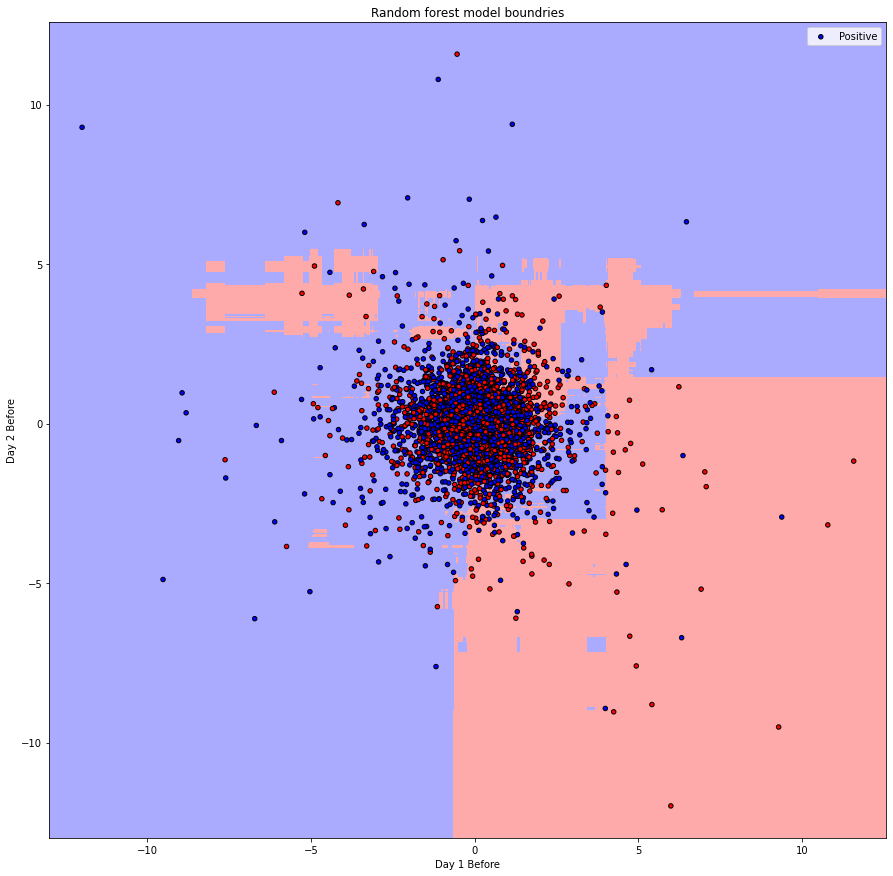

The code took 29.51022 seconds to run.


In [56]:
# Visualizing the Random Forest algorithm
plot_random_forest(Features_D1B_D2B, Y)

In [57]:
plt.savefig('plot_rf.svg', format='svg')

<Figure size 432x288 with 0 Axes>

In [58]:
# Selecting Day_1_before, Day_2_before, Day_3_before as our features
Features_D1B_D2B_D3B = sp500_2[['Day_1_before', 'Day_2_before', 'Day_3_before']]

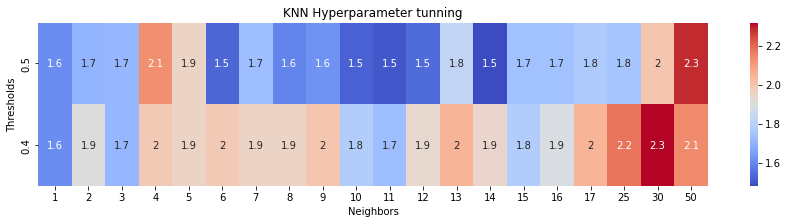

The code took 40.70950 seconds to run.


In [59]:
# Selecting the right parameters for KNN
matrix_knn_parameters_percentage_changes_D1B_D2B_D3B = knn_hyper(Features_D1B_D2B_D3B, Y, sp500_2['2017-9-26':])

In [60]:
matrix_knn_parameters_percentage_changes_D1B_D2B_D3B

array([[1.61, 1.7 , 1.71, 2.13, 1.95, 1.53, 1.73, 1.59, 1.62, 1.52, 1.5 ,
        1.54, 1.82, 1.48, 1.74, 1.74, 1.77, 1.75, 2.  , 2.29],
       [1.61, 1.9 , 1.71, 1.99, 1.95, 1.99, 1.95, 1.95, 2.  , 1.78, 1.73,
        1.93, 2.05, 1.94, 1.78, 1.89, 2.05, 2.18, 2.32, 2.14]])

The parameter combination of 30 neighbors with a threshold of 0.4 results in the highest NORD.

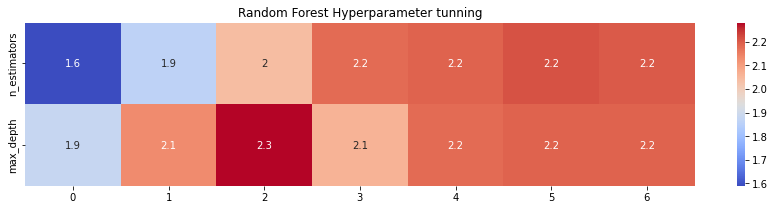

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 23.74523 seconds to run.


In [61]:
# Selecting the right parameters for RF
matrix_rf_parameters_percentage_changes_D1B_D2B_D3B = hypertune_random_forest(Features_D1B_D2B_D3B, Y, sp500_2['2017-9-26':])

In [62]:
matrix_rf_parameters_percentage_changes_D1B_D2B_D3B

array([[1.59, 1.86, 2.04, 2.18, 2.19, 2.21, 2.2 ],
       [1.88, 2.13, 2.28, 2.06, 2.18, 2.19, 2.19]])

A max depth of 10 and n_estimators of 200 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.689107
         Iterations 4
33/33 [==============================] - 1s 2ms/step


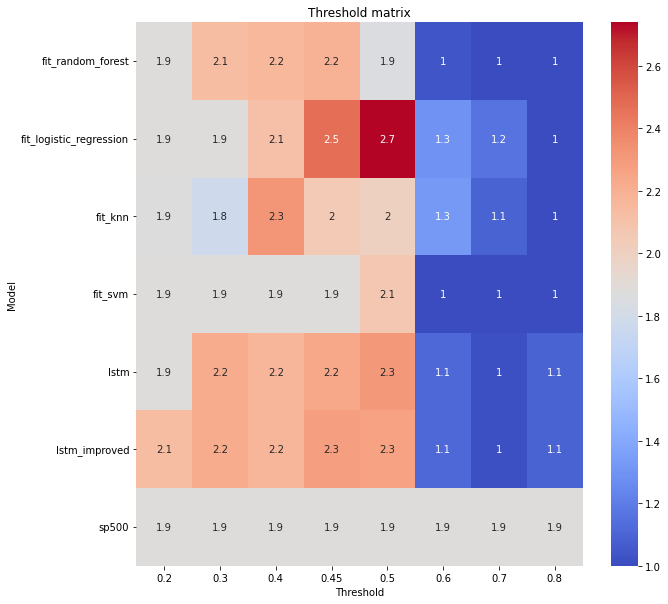

The code took 99.34682 seconds to run.


In [63]:
matrix_D1B_D2B_D3B_threshold = treshold_matrix(Features_D1B_D2B_D3B, Y, sp500_2["2017-9-26":], 3, n_steps=1, n_estimators=200, max_depth=10, neighbors=30)

In [64]:
matrix_D1B_D2B_D3B_threshold

array([[1.88, 2.13, 2.16, 2.19, 1.85, 1.04, 1.  , 1.  ],
       [1.88, 1.88, 2.11, 2.47, 2.74, 1.29, 1.16, 1.  ],
       [1.87, 1.78, 2.32, 2.05, 2.  , 1.32, 1.09, 1.  ],
       [1.88, 1.88, 1.88, 1.88, 2.07, 1.  , 1.  , 1.  ],
       [1.88, 2.22, 2.17, 2.24, 2.31, 1.11, 1.02, 1.09],
       [2.13, 2.22, 2.17, 2.28, 2.27, 1.11, 1.02, 1.09],
       [1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.88]])

The thresholds 0.45, 0.5, 0.4, 0.5, 0.45, 0.45, corresponding to the algorithms Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Long-Short Term Memory, and Long-Short Term Memory Improved, respectively, yield the highest NORD.

Optimization terminated successfully.
         Current function value: 0.689107
         Iterations 4
14/14 [==============================] - 0s 6ms/step


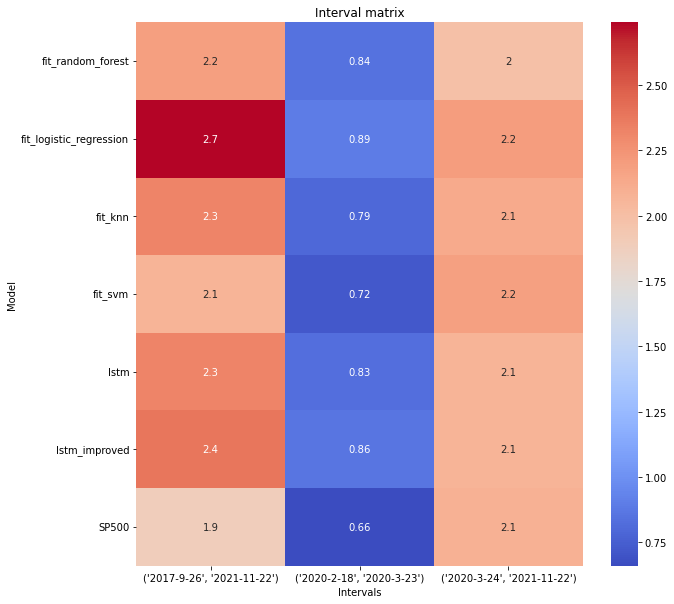

The code took 202.59032 seconds to run.


In [65]:
thresholds_D1B_D2B_D3B = [0.45, 0.5, 0.4, 0.5, 0.45, 0.45]
matrix_D1B_D2B_D3B_interval = interval_matrix(Features_D1B_D2B_D3B, Y, interval1, interval2, interval3, sp500_2["2017-9-26":], 3, thresholds_D1B_D2B_D3B, neighbors=30, n_estimators=200, max_depth=10)

In [66]:
matrix_D1B_D2B_D3B_interval

array([[2.19, 0.84, 1.99],
       [2.74, 0.89, 2.2 ],
       [2.32, 0.79, 2.13],
       [2.07, 0.72, 2.18],
       [2.32, 0.83, 2.07],
       [2.39, 0.86, 2.07],
       [1.88, 0.66, 2.09]])

In [67]:
# Calculating the difference in NORD between interval matrices to identify which algorithms on 
# specific intervals have shown improvement.
print(matrix_D1B_D2B_D3B_interval - matrix_D1B_D2B_interval)

[[-0.52 -0.09 -0.16]
 [ 0.08  0.   -0.04]
 [-0.59 -0.26 -0.02]
 [-0.23 -0.1   0.03]
 [-0.69 -0.1  -0.34]
 [-0.44 -0.03 -0.26]
 [ 0.    0.    0.  ]]


Optimization terminated successfully.
         Current function value: 0.689107
         Iterations 4


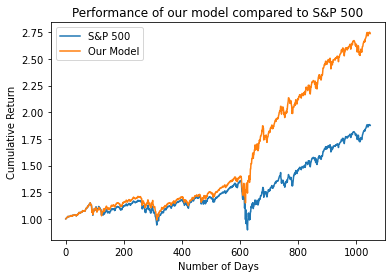

In [68]:
# Generating predictions by using Logistic regression
accuracy_D1B_D2B_D3B, y_test_D1B_D2B_D3B, y_pred_class_D1B_D2B_D3B, y_pred_prob_D1B_D2B_D3B = fit_logistic_regression(Features_D1B_D2B_D3B, Y, threshold = 0.5)
val_return_D1B_D2B_D3B = investment_return(y_pred_class_D1B_D2B_D3B, sp500["2017-9-26":'2021-11-22'])["dollars"].iloc[-1]
# Plotting the results into a graph
plot_investment_performance(y_pred_class_D1B_D2B_D3B, sp500["2017-9-26":'2021-11-22'])

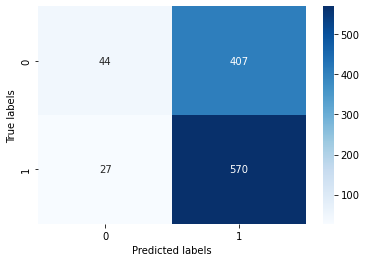

In [69]:
# Generating confusion matrix
c_matrix(y_test_D1B_D2B_D3B, y_pred_class_D1B_D2B_D3B)

In [70]:
plt.savefig('confusion_matrix.svg', format='svg')

<Figure size 432x288 with 0 Axes>

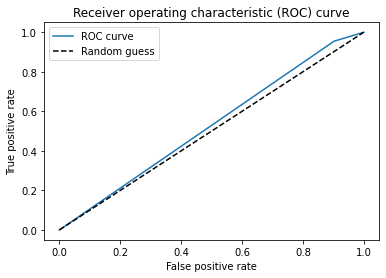

In [71]:
# Generating ROC curve
roc(y_test_D1B_D2B_D3B, y_pred_class_D1B_D2B_D3B)

In [72]:
plt.savefig('roc_curve.svg', format='svg')

<Figure size 432x288 with 0 Axes>

Summary:

Algorithms are trained on the interval from 30.1.2001, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, and trained on the interval from 30.1.2001, until 25.9.2017, is 2.73.

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

Methodology A identifies Day_1_before, Day_4_before, and Day_5_before as important features.

Methodology B identifies the same features as important as Methodology A.

Upon applying common sense, we decide to include additional features to our model: Day_1_before, Day_2_before, and Day_3_before.

Our feature vector changes from an empty set to X=[Day_1_before, Day_2_before, Day_3_before].

## <font color='orange'>Open, Close, High, Low</font>


In [73]:
# Calculating Opening price a day ago, Highest price a day ago, Lowest price a day ago
sp500['Open_day_before'] = sp500['Open'].shift(1)
sp500['High_day_before'] = sp500['Open'].shift(1)
sp500['Low_day_before'] = sp500['Open'].shift(1)

sp500['Open_pct_change'] = (sp500['Open'] - sp500['Open_day_before'])  / sp500['Open_day_before'] * 100
sp500['High_pct_change'] = (sp500['High'] - sp500['High_day_before'])  / sp500['High_day_before'] * 100
sp500['Low_pct_change'] = (sp500['Low'] - sp500['Low_day_before'])  / sp500['Low_day_before'] * 100

sp500['Open_pct_change_Day_before'] = sp500['Open_pct_change'].shift(1)
sp500['High_pct_change_Day_before'] = sp500['High_pct_change'].shift(1)
sp500['Low_pct_change_Day_before'] = sp500['Low_pct_change'].shift(1)

sp500_2 = sp500.loc['2001-01-30':"2021-11-22"]

sp500_2

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,Day_9_before,Open_day_before,High_day_before,Low_day_before,Open_pct_change,High_pct_change,Low_pct_change,Open_pct_change_Day_before,High_pct_change_Day_before,Low_pct_change_Day_before
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-30,1364.170044,1375.680054,1356.199951,1373.729980,1373.729980,1149800000,1364.170044,0.700788,1,0.680475,...,0.212561,1354.920044,1354.920044,1354.920044,0.682697,1.532194,0.094464,-0.190788,0.591526,-0.526701
2001-01-31,1373.729980,1383.369995,1364.660034,1366.010010,1366.010010,1295300000,1373.729980,-0.561971,0,0.700788,...,1.391532,1364.170044,1364.170044,1364.170044,0.700788,1.407446,0.035919,0.682697,1.532194,0.094464
2001-02-01,1366.010010,1373.500000,1359.339966,1373.469971,1373.469971,1118800000,1366.010010,0.546113,1,-0.561971,...,-0.402823,1373.729980,1373.729980,1373.729980,-0.561971,-0.016741,-1.047514,0.700788,1.407446,0.035919
2001-02-02,1373.469971,1376.380005,1348.719971,1349.469971,1349.469971,1048400000,1373.469971,-1.747399,0,0.546113,...,0.026814,1366.010010,1366.010010,1366.010010,0.546113,0.759145,-1.265733,-0.561971,-0.016741,-1.047514
2001-02-05,1349.469971,1354.560059,1344.479980,1354.310059,1354.310059,1013000000,1349.469971,0.358666,1,-1.747399,...,1.303150,1373.469971,1373.469971,1373.469971,-1.747399,-1.376798,-2.110712,0.546113,0.759145,-1.265733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,4679.419922,4714.950195,4679.419922,4700.899902,4700.899902,3972640000,4682.799805,0.386523,1,-0.001074,...,0.646128,4689.299805,4689.299805,4689.299805,-0.210690,0.546998,-0.210690,0.731639,0.906069,0.378490
2021-11-17,4701.500000,4701.500000,4684.410156,4688.669922,4688.669922,3969070000,4700.899902,-0.260163,0,0.386523,...,0.418194,4679.419922,4679.419922,4679.419922,0.471855,0.471855,0.106642,-0.210690,0.546998,-0.210690
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,4704.540039,4226410000,4688.669922,0.338478,1,-0.260163,...,0.373280,4701.500000,4701.500000,4701.500000,-0.016586,0.155265,-0.610873,0.471855,0.471855,0.106642


In [74]:
# Applying methodology A
# Using methodology A for feature selection.
new_features_O_H_L = ['Open_pct_change_Day_before', 'High_pct_change_Day_before', 'Low_pct_change_Day_before']
# We have already decided to include features Day_1_before, Day_2_before, and Day_3_before 
# in our model; therefore, they will be fixed and present in each iteration.
fixed_features = ['Day_1_before', 'Day_2_before', 'Day_3_before']
# The NORD value for Logistic Regression with features Day_1_before, Day_2_before, and Day_3_before 
# on the validation set is 2.73. Therefore, NORD_max = 2.73.
result_O_H_L = methodology_A(fixed_features, new_features_O_H_L, sp500_2, 2.73)
result_O_H_L

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Open_pct_change_Day_before']",2.298728
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'High_pct_change_Day_before']",2.296425
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Low_pct_change_Day_before']",2.183139


Methodology does not identify any of the new features as important because each option yields a lower NORD than the NORD of the feature combination Day_1_before, Day_2_before, Day_3_before.

In [75]:
# Round 1 of methodlogy B
features_round_1_O_H_L = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Open_pct_change_Day_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'High_pct_change_Day_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Low_pct_change_Day_before']
]
result_round_1_O_H_L = best_features(features_round_1_O_H_L, sp500_2)
result_round_1_O_H_L

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before']",2.737197
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Open_pct_change_Day_before']",2.298728
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'High_pct_change_Day_before']",2.296425
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Low_pct_change_Day_before']",2.183139


Methodology B does not select any of the new features as important.

Summary:

Algorithms are trained on the interval from 30.1.2001, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, and trained on the interval from 30.1.2001, until 25.9.2017, is 2.73.

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

Methodologies A and B do not identify any of the new features as important.

Upon applying common sense, we decide to not include any new features to our model.

Our feature vector does not change and remains the same: X=[Day_1_before, Day_2_before, Day_3_before].

## <font color='orange'>Opening Price of the Targeted Day</font>

In [76]:
# Calculating the Percentage Change between the Open price and Close price
sp500['Change_Open_Close'] = (sp500['Open'] - sp500['Close day before']) / sp500['Close day before']*100
sp500_2 = sp500.loc['2001-01-30':"2021-11-22"]
sp500_2

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,Open_day_before,High_day_before,Low_day_before,Open_pct_change,High_pct_change,Low_pct_change,Open_pct_change_Day_before,High_pct_change_Day_before,Low_pct_change_Day_before,Change_Open_Close
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-30,1364.170044,1375.680054,1356.199951,1373.729980,1373.729980,1149800000,1364.170044,0.700788,1,0.680475,...,1354.920044,1354.920044,1354.920044,0.682697,1.532194,0.094464,-0.190788,0.591526,-0.526701,0.000000
2001-01-31,1373.729980,1383.369995,1364.660034,1366.010010,1366.010010,1295300000,1373.729980,-0.561971,0,0.700788,...,1364.170044,1364.170044,1364.170044,0.700788,1.407446,0.035919,0.682697,1.532194,0.094464,0.000000
2001-02-01,1366.010010,1373.500000,1359.339966,1373.469971,1373.469971,1118800000,1366.010010,0.546113,1,-0.561971,...,1373.729980,1373.729980,1373.729980,-0.561971,-0.016741,-1.047514,0.700788,1.407446,0.035919,0.000000
2001-02-02,1373.469971,1376.380005,1348.719971,1349.469971,1349.469971,1048400000,1373.469971,-1.747399,0,0.546113,...,1366.010010,1366.010010,1366.010010,0.546113,0.759145,-1.265733,-0.561971,-0.016741,-1.047514,0.000000
2001-02-05,1349.469971,1354.560059,1344.479980,1354.310059,1354.310059,1013000000,1349.469971,0.358666,1,-1.747399,...,1373.469971,1373.469971,1373.469971,-1.747399,-1.376798,-2.110712,0.546113,0.759145,-1.265733,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,4679.419922,4714.950195,4679.419922,4700.899902,4700.899902,3972640000,4682.799805,0.386523,1,-0.001074,...,4689.299805,4689.299805,4689.299805,-0.210690,0.546998,-0.210690,0.731639,0.906069,0.378490,-0.072177
2021-11-17,4701.500000,4701.500000,4684.410156,4688.669922,4688.669922,3969070000,4700.899902,-0.260163,0,0.386523,...,4679.419922,4679.419922,4679.419922,0.471855,0.471855,0.106642,-0.210690,0.546998,-0.210690,0.012766
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,4704.540039,4226410000,4688.669922,0.338478,1,-0.260163,...,4701.500000,4701.500000,4701.500000,-0.016586,0.155265,-0.610873,0.471855,0.471855,0.106642,0.257009


In [77]:
# Selecting features
Features_D1B_D2B_D3B_COC = sp500_2[['Day_1_before', 'Day_2_before', 'Day_3_before', 'Change_Open_Close']]

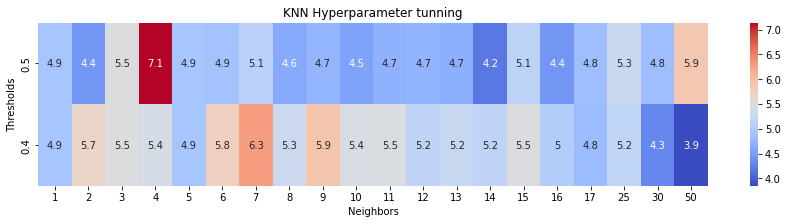

The code took 41.40019 seconds to run.


In [78]:
# Selecting the right parameters for KNN
matrix_knn_parameters_COC = knn_hyper(Features_D1B_D2B_D3B_COC, Y, sp500_2['2017-9-26':])

In [79]:
matrix_knn_parameters_COC

array([[4.92, 4.44, 5.48, 7.14, 4.92, 4.88, 5.1 , 4.61, 4.73, 4.55, 4.69,
        4.72, 4.68, 4.19, 5.13, 4.43, 4.83, 5.27, 4.83, 5.87],
       [4.92, 5.68, 5.48, 5.4 , 4.92, 5.75, 6.29, 5.28, 5.9 , 5.42, 5.45,
        5.16, 5.24, 5.15, 5.46, 5.04, 4.81, 5.17, 4.31, 3.85]])

The parameter combination of 4 neighbors with a threshold of 0.5 results in the highest NORD.

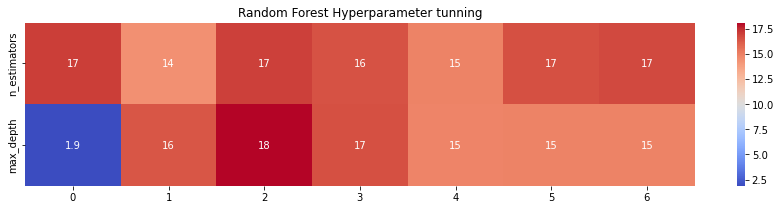

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 24.46156 seconds to run.


In [80]:
# Selecting the right parameters for RF
matrix_rf_parameters_COC = hypertune_random_forest(Features_D1B_D2B_D3B_COC, Y, sp500_2['2017-9-26':])

In [81]:
matrix_rf_parameters_COC

array([[17.05, 14.41, 16.99, 16.5 , 14.9 , 16.52, 16.71],
       [ 1.88, 16.33, 18.09, 16.57, 14.84, 14.9 , 14.9 ]])

A max depth of 5 and n_estimators of 3 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.646107
         Iterations 6
33/33 [==============================] - 1s 2ms/step


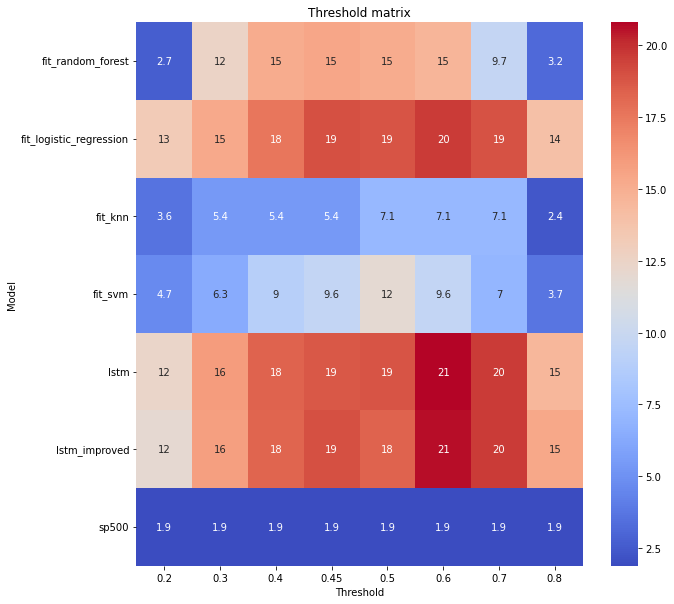

The code took 95.44896 seconds to run.


In [82]:
matrix_D1B_D2B_D3B_COC_threshold = treshold_matrix(Features_D1B_D2B_D3B_COC, Y, sp500_2["2017-9-26":], 4, n_steps=1, n_estimators=3, max_depth=5, neighbors=4)

In [83]:
matrix_D1B_D2B_D3B_COC_threshold

array([[ 2.69, 12.5 , 15.13, 15.45, 15.12, 14.66,  9.68,  3.16],
       [13.26, 15.33, 17.59, 19.  , 18.82, 19.65, 18.9 , 13.98],
       [ 3.61,  5.4 ,  5.4 ,  5.4 ,  7.14,  7.14,  7.14,  2.37],
       [ 4.68,  6.33,  8.96,  9.63, 11.86,  9.59,  6.99,  3.67],
       [12.32, 15.96, 18.31, 18.7 , 18.83, 20.8 , 19.68, 14.58],
       [12.  , 15.79, 18.23, 19.  , 18.3 , 20.61, 19.67, 15.35],
       [ 1.88,  1.88,  1.88,  1.88,  1.88,  1.88,  1.88,  1.88]])

The thresholds 0.5, 0.6, 0.6, 0.5, 0.6, 0.6, corresponding to the algorithms Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Long-Short Term Memory, and Long-Short Term Memory Improved, respectively, yield the highest NORD.

In [84]:
thresholds_D1B_D2B_D3B_COC = [0.5, 0.6, 0.6, 0.5, 0.6, 0.6]

Optimization terminated successfully.
         Current function value: 0.646107
         Iterations 6
14/14 [==============================] - 0s 4ms/step


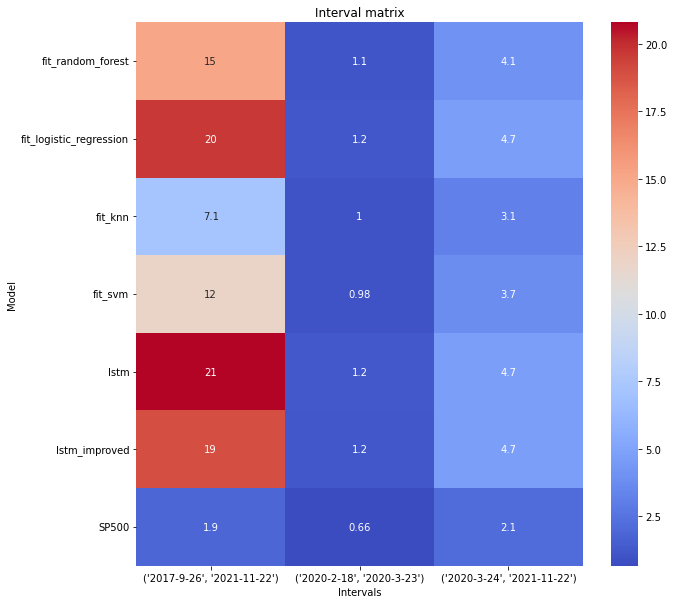

The code took 195.62787 seconds to run.


In [85]:
matrix_D1B_D2B_D3B_COC_interval = interval_matrix(Features_D1B_D2B_D3B_COC, Y, interval1, interval2, interval3, sp500_2["2017-9-26":], 4, thresholds_D1B_D2B_D3B_COC, neighbors=4, n_estimators=3, max_depth=5)

In [86]:
matrix_D1B_D2B_D3B_COC_interval

array([[15.12,  1.08,  4.09],
       [19.65,  1.2 ,  4.74],
       [ 7.14,  1.04,  3.14],
       [11.86,  0.98,  3.73],
       [20.8 ,  1.23,  4.71],
       [18.93,  1.2 ,  4.71],
       [ 1.88,  0.66,  2.09]])

In [87]:
# Dropping unnecessary columns
sp500 = sp500.drop(columns=['Change_Open_Close'])

Summary:

Algorithms are trained on the interval from 30.1.2001, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, and trained on the interval from 30.1.2001, until 25.9.2017, is 2.73.

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

The feature Change_Open_Close significantly improved the NORD across all algorithms. However, there is a logical error. Incorporating this feature into our model would allow our model to 'see' the future. Therefore, we will not include this feature in our model.

Our feature vector does not change and remains the same: X=[Day_1_before, Day_2_before, Day_3_before].

## <font color='orange'>Volume</font>

In [88]:
# Calculating percentage change in volume one day before
sp500['Volume'] = sp500['Volume'] / 1000000
sp500['Volume day before'] = sp500['Volume'].shift(1)
sp500['Change_volume'] = ((sp500['Volume'] - sp500['Volume day before']) / sp500['Volume day before']*100).shift(1)
sp500_2 = sp500.loc['2001-01-30':"2021-11-22"]
sp500_2

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,High_day_before,Low_day_before,Open_pct_change,High_pct_change,Low_pct_change,Open_pct_change_Day_before,High_pct_change_Day_before,Low_pct_change_Day_before,Volume day before,Change_volume
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-30,1364.170044,1375.680054,1356.199951,1373.729980,1373.729980,1149.80,1364.170044,0.700788,1,0.680475,...,1354.920044,1354.920044,0.682697,1.532194,0.094464,-0.190788,0.591526,-0.526701,1053.10,-4.089253
2001-01-31,1373.729980,1383.369995,1364.660034,1366.010010,1366.010010,1295.30,1373.729980,-0.561971,0,0.700788,...,1364.170044,1364.170044,0.700788,1.407446,0.035919,0.682697,1.532194,0.094464,1149.80,9.182414
2001-02-01,1366.010010,1373.500000,1359.339966,1373.469971,1373.469971,1118.80,1366.010010,0.546113,1,-0.561971,...,1373.729980,1373.729980,-0.561971,-0.016741,-1.047514,0.700788,1.407446,0.035919,1295.30,12.654375
2001-02-02,1373.469971,1376.380005,1348.719971,1349.469971,1349.469971,1048.40,1373.469971,-1.747399,0,0.546113,...,1366.010010,1366.010010,0.546113,0.759145,-1.265733,-0.561971,-0.016741,-1.047514,1118.80,-13.626187
2001-02-05,1349.469971,1354.560059,1344.479980,1354.310059,1354.310059,1013.00,1349.469971,0.358666,1,-1.747399,...,1373.469971,1373.469971,-1.747399,-1.376798,-2.110712,0.546113,0.759145,-1.265733,1048.40,-6.292456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,4679.419922,4714.950195,4679.419922,4700.899902,4700.899902,3972.64,4682.799805,0.386523,1,-0.001074,...,4689.299805,4689.299805,-0.210690,0.546998,-0.210690,0.731639,0.906069,0.378490,3488.41,-6.441828
2021-11-17,4701.500000,4701.500000,4684.410156,4688.669922,4688.669922,3969.07,4700.899902,-0.260163,0,0.386523,...,4679.419922,4679.419922,0.471855,0.471855,0.106642,-0.210690,0.546998,-0.210690,3972.64,13.881109
2021-11-18,4700.720215,4708.799805,4672.779785,4704.540039,4704.540039,4226.41,4688.669922,0.338478,1,-0.260163,...,4701.500000,4701.500000,-0.016586,0.155265,-0.610873,0.471855,0.471855,0.106642,3969.07,-0.089865


In [89]:
# Methodology A
features_V_CV = ['Volume day before', 'Change_volume']
fixed_features = ['Day_1_before', 'Day_2_before', 'Day_3_before']
result_V_CV = methodology_A(fixed_features, features_V_CV, sp500_2, 2.73)
result_V_CV

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Volume day before']",1.875682
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Change_volume']",2.688102


Methodology does not identify any of the new features as important because each option yields a lower NORD than the NORD of the feature combination Day_1_before, Day_2_before, Day_3_before. The NORD value of the feature combination Day_1_before, Day_2_before, Day_3_before is 2.73.

In [90]:
# Round 1 of methodlogy B
Features_round_1_V_CV = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Volume'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'Change_volume'],
]
result_round_1_V_CV = best_features(Features_round_1_V_CV, sp500_2)
result_round_1_V_CV

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before']",2.737197
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Volume']",1.875682
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'Change_volume']",2.688102


Methodologies A does not deem any of the new features important.

## <font color='orange'>VIX</font>

In [91]:
# Downloading data of VIX index
yahoo_financials = YahooFinancials('^VIX')
hist_market_data = yahoo_financials.get_historical_price_data('2001-01-18', '2024-1-24', 'daily')
prices_data = hist_market_data['^VIX']['prices']
df_VIX = pd.DataFrame(prices_data)
df_VIX['formatted_date'] = pd.to_datetime(df_VIX['formatted_date'])
df_VIX.set_index('formatted_date', inplace=True)
df_VIX

,date,high,low,open,close,volume,adjclose
formatted_date,,,,,,,
2001-01-18,979804800,24.530001,23.180000,24.480000,23.370001,0.0,23.370001
2001-01-19,979891200,24.080000,23.000000,23.620001,23.240000,0.0,23.240000
2001-01-22,980150400,24.309999,23.240000,24.270000,23.250000,0.0,23.250000
2001-01-23,980236800,23.150000,21.469999,23.000000,21.570000,0.0,21.570000
2001-01-24,980323200,22.410000,21.870001,21.980000,22.030001,0.0,22.030001
...,...,...,...,...,...,...,...
2024-01-17,1705478400,15.400000,14.380000,14.590000,14.790000,0.0,14.790000
2024-01-18,1705564800,14.890000,13.890000,14.850000,14.130000,0.0,14.130000
2024-01-19,1705651200,14.580000,13.280000,13.800000,13.300000,0.0,13.300000


In [92]:
# Mergind dataframe df_VIX and sp500 into single dataframe
merged_df_VIX = sp500.merge(df_VIX, how='inner', left_index=True, right_index=True, suffixes=('_SP500', '_VIX'))
merged_df_VIX['VIX_Close_day_before'] = merged_df_VIX['close'].shift(1)
merged_df_VIX['VIX_change'] = (((merged_df_VIX['close'] - merged_df_VIX['VIX_Close_day_before']) / merged_df_VIX['VIX_Close_day_before'])*100).shift(1)
merged_df_VIX

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,Change_volume,date,high,low,open,close,volume,adjclose,VIX_Close_day_before,VIX_change
2001-01-18,1329.890015,1352.709961,1327.410034,1347.969971,1347.969971,1445.00,1329.469971,1.391532,1,0.212561,...,11.893506,979804800,24.530001,23.180000,24.480000,23.370001,0.0,23.370001,NaN,NaN
2001-01-19,1347.969971,1354.550049,1336.739990,1342.540039,1342.540039,1407.80,1347.969971,-0.402823,0,1.391532,...,7.108443,979891200,24.080000,23.000000,23.620001,23.240000,0.0,23.240000,23.370001,NaN
2001-01-22,1342.540039,1353.619995,1333.839966,1342.900024,1342.900024,1164.00,1342.540039,0.026814,1,-0.402823,...,-2.574394,980150400,24.309999,23.240000,24.270000,23.250000,0.0,23.250000,23.240000,-0.556273
2001-01-23,1342.900024,1362.900024,1339.630005,1360.400024,1360.400024,1232.60,1342.900024,1.303150,1,0.026814,...,-17.317801,980236800,23.150000,21.469999,23.000000,21.570000,0.0,21.570000,23.250000,0.043030
2001-01-24,1360.400024,1369.750000,1357.280029,1364.300049,1364.300049,1309.00,1360.400024,0.286682,1,1.303150,...,5.893471,980323200,22.410000,21.870001,21.980000,22.030001,0.0,22.030001,21.570000,-7.225808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928.60,4765.979980,-0.561690,0,-0.373134,...,22.206956,1705478400,15.400000,14.380000,14.590000,14.790000,0.0,14.790000,13.840000,8.976381
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019.00,4739.209961,0.880526,1,-0.561690,...,-7.791248,1705564800,14.890000,13.890000,14.850000,14.130000,0.0,14.130000,14.790000,6.864160
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287.20,4780.939941,1.231350,1,0.880526,...,2.301074,1705651200,14.580000,13.280000,13.800000,13.300000,0.0,13.300000,14.130000,-4.462474
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297.61,4839.810059,0.219433,1,1.231350,...,6.673302,1705910400,13.840000,13.170000,13.770000,13.190000,0.0,13.190000,13.300000,-5.874026


In [93]:
merged_df_2_VIX = merged_df_VIX['2001-01-30':"2021-11-23"]
# Applying methodology A and B
features_round_1_VIX = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'VIX_change']
]
result_round_1_VIX = best_features(features_round_1_VIX, merged_df_2_VIX)
result_round_1_VIX

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before']",2.737197
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'VIX_change']",2.663728


Summary:

Algorithms are trained on the interval from 30.1.2001, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, and trained on the interval from 30.1.2001, until 25.9.2017, is 2.73.

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

Methodologies A and B do not identify the VIX_change as important.

Upon applying common sense, we decide to not include VIX_change to our model.

Our feature vector does not change and remains the same: X=[Day_1_before, Day_2_before, Day_3_before].

## <font color='orange'>Currency exchange rates</font>

In [94]:
# Defining the currencies we are interested in
currencies = ['EURUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CHFUSD=X', 'CNYUSD=X', 'ZARUSD=X', 'BRLUSD=X']
currencies_df = yf.download(currencies, start='2001-01-18', end='2024-1-24')['Close']
# Renaming columns for clarity
currencies_df.columns = ['EUR', 'GBP', 'JPY', 'CHF', 'CNY', 'ZAR', 'BRL']
# Changing the index format to 'YYYY-MM-DD'
currencies_df.index = currencies_df.index.strftime('%Y-%m-%d')
# Converting index to datetime
currencies_df.index = pd.to_datetime(currencies_df.index)
currencies_df

[*********************100%***********************]  7 of 7 completed


,EUR,GBP,JPY,CHF,CNY,ZAR,BRL
Date,,,,,,,
2001-01-18,NaN,NaN,NaN,NaN,NaN,0.008482,NaN
2001-01-19,NaN,NaN,NaN,NaN,NaN,0.008538,NaN
2001-01-22,NaN,NaN,NaN,NaN,NaN,0.008587,NaN
2001-01-23,NaN,NaN,NaN,NaN,NaN,0.008576,NaN
2001-01-24,NaN,NaN,NaN,NaN,NaN,0.008482,NaN
...,...,...,...,...,...,...,...
2024-01-17,0.203050,1.161036,0.140519,1.087879,1.263855,0.006791,0.052745
2024-01-18,0.202675,1.156976,0.140558,1.088578,1.267684,0.006751,0.052413
2024-01-19,0.203000,1.151968,0.140548,1.087914,1.270987,0.006751,0.052851


In [95]:
# Identifying the earliest date with non-NaN values for each currency.
first_non_nan_dates = currencies_df.apply(lambda col: col.dropna().index.min())
first_non_nan_dates

EUR   2003-12-01
GBP   2003-09-17
JPY   2001-06-25
CHF   2003-12-01
CNY   2003-12-01
ZAR   2001-01-18
BRL   2003-12-01
dtype: datetime64[ns]

In [96]:
# Eliminating NaN values from the dataset.
currencies_df_2 = currencies_df['2003-12-01':]
currencies_df_2

,EUR,GBP,JPY,CHF,CNY,ZAR,BRL
Date,,,,,,,
2003-12-01,0.342114,0.770357,0.120960,1.196501,1.718597,0.009160,0.157672
2003-12-02,0.341180,0.776880,0.120960,1.208897,1.730313,0.009197,0.158854
2003-12-03,0.341180,0.778089,0.120961,1.212298,1.728101,0.009234,0.161488
2003-12-04,0.339789,0.776096,0.120963,1.208094,1.720697,0.009236,0.157851
2003-12-05,0.340832,0.785916,0.120964,1.218695,1.733102,0.009292,0.160769
...,...,...,...,...,...,...,...
2024-01-17,0.203050,1.161036,0.140519,1.087879,1.263855,0.006791,0.052745
2024-01-18,0.202675,1.156976,0.140558,1.088578,1.267684,0.006751,0.052413
2024-01-19,0.203000,1.151968,0.140548,1.087914,1.270987,0.006751,0.052851


In [97]:
# We want to merge currencies_df and sp500. Therefore we want the same dates for each.
sp500_3 = merged_df_VIX['2003-12-01':]

# Merging currencies_df and sp500_3 into one dataframe
merged_df_currencies = sp500_3.merge(currencies_df, how='inner', left_index=True, right_index=True, suffixes=('_SP500', '_currencies'))

# Calculating Percentage change of each currency one day before
currencies = ['EUR', 'GBP', 'JPY', 'CHF', 'CNY', 'ZAR', 'BRL']
for currency in currencies:
    merged_df_currencies[currency + str('Day before')] = merged_df_currencies[currency].shift(1)
    merged_df_currencies[currency + str('change')] = (((merged_df_currencies[currency] - merged_df_currencies[currency + str('Day before')]) / merged_df_currencies[currency + str('Day before')])*100).shift(1)
# Eliminating NaNs
merged_df_currencies = merged_df_currencies['2003-12-03':]
merged_df_currencies

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,JPYDay before,JPYchange,CHFDay before,CHFchange,CNYDay before,CNYchange,ZARDay before,ZARchange,BRLDay before,BRLchange
2003-12-03,1066.619995,1074.300049,1064.630005,1064.729980,1064.729980,1441.70,1066.619995,-0.177197,0,-0.327066,...,0.120960,0.000000,1.208897,1.036029,1.730313,0.681747,0.009197,0.404667,0.158854,0.749786
2003-12-04,1064.729980,1070.369995,1063.150024,1069.719971,1069.719971,1463.10,1064.729980,0.468663,1,-0.177197,...,0.120961,0.001226,1.212298,0.281255,1.728101,-0.127889,0.009234,0.397041,0.161488,1.658488
2003-12-05,1069.719971,1069.719971,1060.089966,1061.500000,1061.500000,1265.90,1069.719971,-0.768423,0,0.468663,...,0.120963,0.001207,1.208094,-0.346723,1.720697,-0.428446,0.009236,0.027717,0.157851,-2.252536
2003-12-08,1061.500000,1069.589966,1060.930054,1069.300049,1069.300049,1218.90,1061.500000,0.734814,1,-0.768423,...,0.120964,0.001213,1.218695,0.877452,1.733102,0.720966,0.009292,0.603967,0.160769,1.848850
2003-12-09,1069.300049,1071.939941,1059.160034,1060.180054,1060.180054,1465.50,1069.300049,-0.852894,0,0.734814,...,0.120961,-0.002421,1.222001,0.271296,1.734214,0.064168,0.009310,0.195517,0.155732,-3.133321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928.60,4765.979980,-0.561690,0,-0.373134,...,0.140905,0.085946,1.094571,-0.327277,1.271617,-0.481949,0.006859,-0.513058,0.053622,-0.021449
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019.00,4739.209961,0.880526,1,-0.561690,...,0.140519,-0.274007,1.087879,-0.611375,1.263855,-0.610438,0.006791,-0.986098,0.052745,-1.635047
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287.20,4780.939941,1.231350,1,0.880526,...,0.140558,0.028112,1.088578,0.064214,1.267684,0.302981,0.006751,-0.588721,0.052413,-0.629537
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297.61,4839.810059,0.219433,1,1.231350,...,0.140548,-0.007029,1.087914,-0.060920,1.270987,0.260548,0.006751,-0.006752,0.052851,0.835571


In [98]:
merged_df_currencies[['EUR', 'EURDay before', 'EURchange']]

,EUR,EURDay before,EURchange
2003-12-03,0.341180,0.341180,-0.272940
2003-12-04,0.339789,0.341180,0.000000
2003-12-05,0.340832,0.339789,-0.407744
2003-12-08,0.340136,0.340832,0.306751
2003-12-09,0.340948,0.340136,-0.204085
...,...,...,...
2024-01-17,0.203050,0.205668,0.154257
2024-01-18,0.202675,0.203050,-1.273127
2024-01-19,0.203000,0.202675,-0.184436
2024-01-22,0.203888,0.203000,0.160374


In [99]:
# Filling up NaNs
merged_df_currencies = merged_df_currencies.fillna(method='ffill')
merged_df_currencies = merged_df_currencies.fillna(method='bfill')
merged_df_currencies_2 = merged_df_currencies['2003-12-03':'2021-11-22']
print(merged_df_currencies_2.isna().sum())

Open                          0
High                          0
Low                           0
Close                         0
Adj Close                     0
Volume                        0
Close day before              0
pct_change                    0
Direction                     0
Day_1_before                  0
Day_2_before                  0
Day_3_before                  0
Day_4_before                  0
Day_5_before                  0
Day_6_before                  0
Day_7_before                  0
Day_8_before                  0
Day_9_before                  0
Open_day_before               0
High_day_before               0
Low_day_before                0
Open_pct_change               0
High_pct_change               0
Low_pct_change                0
Open_pct_change_Day_before    0
High_pct_change_Day_before    0
Low_pct_change_Day_before     0
Volume day before             0
Change_volume                 0
date                          0
high                          0
low     

The NORD_max varies and is not equal to 2.73 due to changes in the training data. The training set interval switches from (30.2001, 22.11.2022) to (3.12.2003, 22.11.2022). As the model is trained on different data, it generates different predictions.

In [100]:
# Calculating NORD_max
nord_max_currencies = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before']
]
result_nord_max = best_features(nord_max_currencies, merged_df_currencies_2)
result_nord_max

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before']",2.625732


In [101]:
# Using methodology A for feature selection
features_currencies = ['EURchange', 'GBPchange', 'JPYchange', 'CHFchange', 'CNYchange', 
                       'ZARchange', 'BRLchange']
fixed_features = ['Day_1_before', 'Day_2_before', 'Day_3_before']
result_currencies = methodology_A(fixed_features, features_currencies, merged_df_currencies_2, 2.63)
result_currencies

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange']",2.696823
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange']",2.771793
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange', 'JPYchange']",2.956301
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange', 'JPYchange', 'CHFchange']",2.956301
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange', 'JPYchange', 'CNYchange']",2.959976
5,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange', 'JPYchange', 'CNYchange', 'ZARchange']",2.894681
6,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange', 'GBPchange', 'JPYchange', 'CNYchange', 'BRLchange']",2.680619


Methodology A identifies features EURchange, GBPchange, JPYchange, CNYchange as important.

In [102]:
# Round 1 of methodology B
features_round_1_currencies = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'CHFchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'CNYchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'ZARchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'BRLchange']
]
result_round_1_currencies = best_features(features_round_1_currencies, merged_df_currencies_2)
result_round_1_currencies

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before']",2.625732
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'EURchange']",2.696823
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange']",2.794637
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange']",2.803825
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'CHFchange']",2.666352
5,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'CNYchange']",2.573542
6,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'ZARchange']",2.661710
7,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'BRLchange']",2.415614


In [103]:
# Round 2 of methodology B
features_round_2_currencies = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'EURchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'GBPchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CHFchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'ZARchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'BRLchange']
]
result_round_2_currencies = best_features(features_round_2_currencies, merged_df_currencies_2)
result_round_2_currencies

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'EURchange']",2.851567
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'GBPchange']",2.956301
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CHFchange']",2.921723
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange']",2.962380
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'ZARchange']",2.769125
5,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'BRLchange']",2.933927


In [104]:
# Round 3 of methodology B
features_round_3_currencies = [
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'EURchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'CHFchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'ZARchange'],
    ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'BRLchange']
]
result_round_3_currencies = best_features(features_round_3_currencies, merged_df_currencies_2)
result_round_3_currencies

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'EURchange']",2.957387
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange']",2.959976
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'CHFchange']",2.840223
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'ZARchange']",2.961366
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'BRLchange']",2.936024


Methodology B identifies features JPYchange, CNYchange as important.

In [105]:
# Using methodology A for feature selection with different order
features_currencies = ['GBPchange', 'EURchange', 'JPYchange', 'GBPchange', 'CHFchange', 'CNYchange', 
                       'ZARchange', 'BRLchange']
fixed_features = ['Day_1_before', 'Day_2_before', 'Day_3_before']
result_currencies = methodology_A(fixed_features, features_currencies, merged_df_currencies_2, 2.63)
result_currencies

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange']",2.794637
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'EURchange']",2.771793
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange']",2.956301
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange', 'GBPchange']",2.956301
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange', 'CHFchange']",2.956301
5,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange', 'CNYchange']",2.959976
6,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange', 'CNYchange', 'ZARchange']",2.894681
7,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'GBPchange', 'JPYchange', 'CNYchange', 'BRLchange']",2.837698


If we alter the order and switch EURchange and GBPchange, the methodology does not identify the feature EURchange as important.

In [106]:
Features_currencies = merged_df_currencies_2[['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange']]
Y_currencies =  merged_df_currencies_2['Direction']

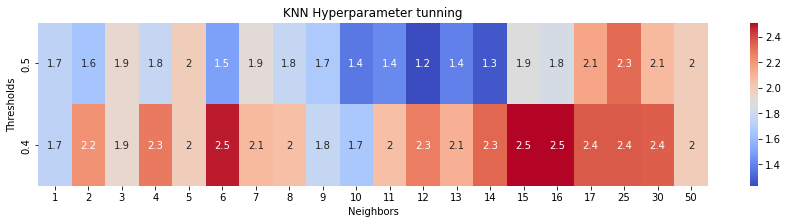

The code took 42.59273 seconds to run.


In [107]:
matrix_knn_parameters_currencies = knn_hyper(Features_currencies, Y_currencies, merged_df_currencies_2['2017-9-26':])

In [108]:
matrix_knn_parameters_currencies

array([[1.73, 1.64, 1.92, 1.76, 1.98, 1.49, 1.89, 1.76, 1.67, 1.36, 1.42,
        1.23, 1.39, 1.26, 1.87, 1.83, 2.15, 2.32, 2.07, 1.98],
       [1.73, 2.21, 1.92, 2.28, 1.98, 2.48, 2.07, 2.05, 1.76, 1.66, 2.05,
        2.27, 2.11, 2.33, 2.51, 2.51, 2.36, 2.36, 2.35, 1.99]])

The parameter combination of 15 neighbors with a threshold of 0.4 results in the highest NORD.

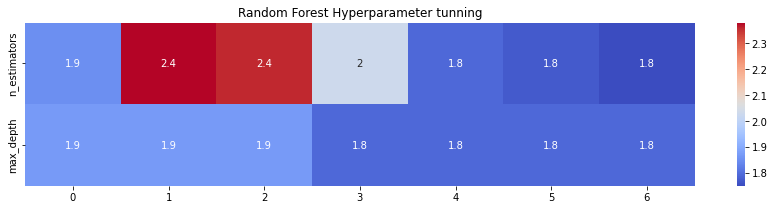

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 24.09786 seconds to run.


In [109]:
matrix_rf_parameters_currencies = hypertune_random_forest(Features_currencies, Y_currencies, merged_df_currencies_2['2017-9-26':])

In [110]:
matrix_rf_parameters_currencies

array([[1.85, 2.38, 2.36, 2.03, 1.79, 1.77, 1.75],
       [1.87, 1.87, 1.87, 1.79, 1.79, 1.79, 1.79]])

A max depth of 5 and n_estimators of 5 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.686413
         Iterations 5
33/33 [==============================] - 1s 2ms/step


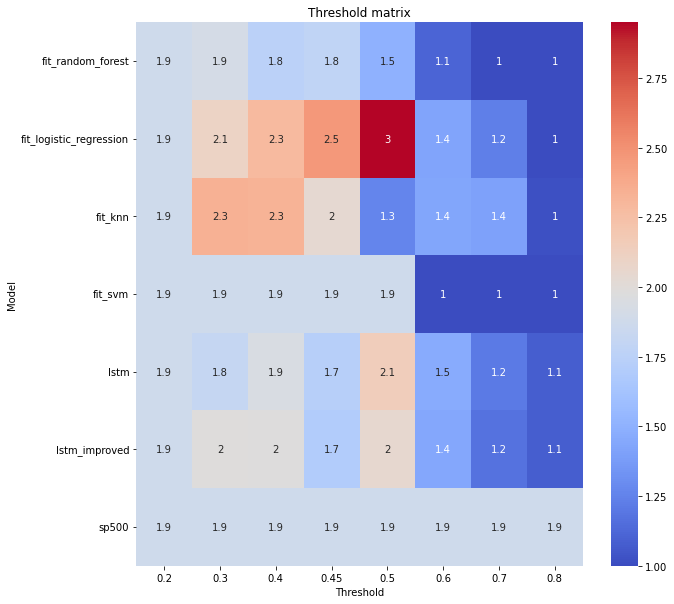

The code took 88.47010 seconds to run.


In [111]:
matrix_currencies_threshold = treshold_matrix(Features_currencies, Y_currencies, merged_df_currencies_2['2017-9-26':], 6, n_steps=1, n_estimators=5, max_depth=5, neighbors=14)

In [112]:
matrix_currencies_threshold

array([[1.87, 1.91, 1.75, 1.78, 1.5 , 1.11, 1.  , 1.  ],
       [1.87, 2.1 , 2.28, 2.47, 2.95, 1.42, 1.23, 1.  ],
       [1.87, 2.34, 2.33, 2.04, 1.26, 1.43, 1.41, 1.02],
       [1.87, 1.87, 1.87, 1.87, 1.87, 1.  , 1.  , 1.  ],
       [1.87, 1.81, 1.94, 1.73, 2.15, 1.46, 1.21, 1.08],
       [1.87, 1.99, 1.98, 1.7 , 2.05, 1.44, 1.17, 1.08],
       [1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87]])

The thresholds 0.4, 0.5, 0.4, 0.5, 0.4, 0.4, corresponding to the algorithms Random Forest, Logistic Regression, K-Nearest Neighbors, Support Vector Classifier, Long-Short Term Memory, and Long-Short Term Memory Improved, respectively, yield the highest NORD.

In [113]:
thresholds_currencies = [0.4, 0.5, 0.4, 0.5, 0.4, 0.4]

Optimization terminated successfully.
         Current function value: 0.686413
         Iterations 5
14/14 [==============================] - 0s 4ms/step


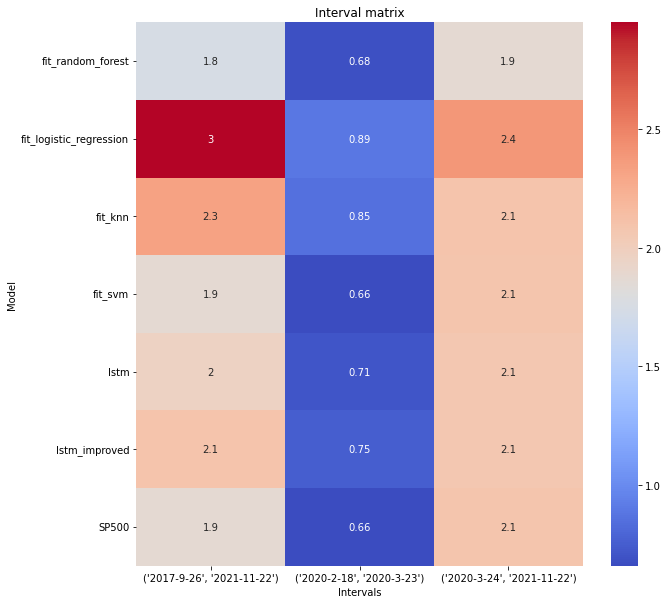

The code took 165.60821 seconds to run.


In [114]:
matrix_currencies_interval = interval_matrix(Features_currencies, Y_currencies, interval1, interval2, interval3, merged_df_currencies_2['2017-9-25':], 6, thresholds_currencies, neighbors=14, n_estimators=5, max_depth=5)

In [115]:
matrix_currencies_interval

array([[1.75, 0.68, 1.87],
       [2.95, 0.89, 2.39],
       [2.33, 0.85, 2.1 ],
       [1.87, 0.66, 2.09],
       [1.96, 0.71, 2.07],
       [2.1 , 0.75, 2.07],
       [1.87, 0.66, 2.09]])

In [116]:
# Finding the interval matrix on this interval
Features_currencies_D1B_D2b_D3B = merged_df_currencies_2[['Day_1_before', 'Day_2_before', 'Day_3_before']]

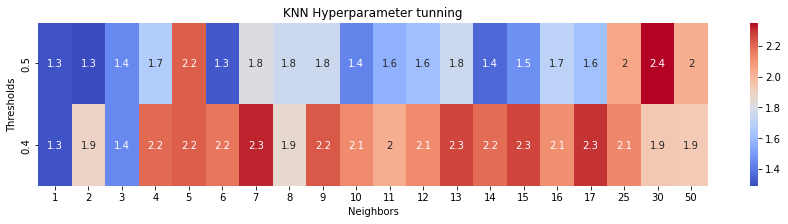

The code took 42.44851 seconds to run.


In [117]:
matrix_knn_parameters_currencies_D1B_D2B_D3B = knn_hyper(Features_currencies_D1B_D2b_D3B, Y_currencies, merged_df_currencies_2['2017-9-26':])

In [118]:
matrix_knn_parameters_currencies_D1B_D2B_D3B 

array([[1.31, 1.29, 1.44, 1.67, 2.22, 1.32, 1.81, 1.75, 1.75, 1.43, 1.56,
        1.61, 1.75, 1.36, 1.46, 1.7 , 1.62, 2.05, 2.35, 2.03],
       [1.31, 1.89, 1.44, 2.2 , 2.22, 2.17, 2.32, 1.86, 2.23, 2.12, 2.03,
        2.12, 2.27, 2.19, 2.27, 2.11, 2.3 , 2.13, 1.94, 1.93]])

The parameter combination of 30 neighbors with a threshold of 0.5 results in the highest NORD.

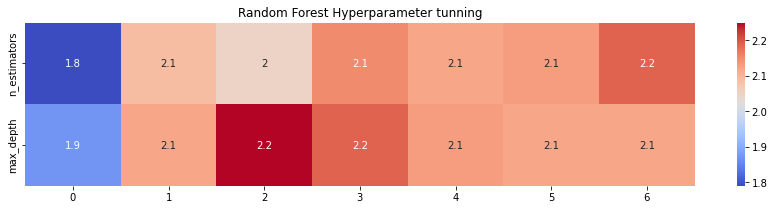

n_estimators: [3, 5, 10, 50, 100, 150, 200]
max_debths: [1, 3, 5, 10, 20, 40, 80]
The code took 20.83182 seconds to run.


In [119]:
matrix_rf_parameters_currencies = hypertune_random_forest(Features_currencies_D1B_D2b_D3B, Y_currencies, merged_df_currencies_2['2017-9-26':])

In [120]:
matrix_rf_parameters_currencies

array([[1.79, 2.09, 2.05, 2.15, 2.12, 2.13, 2.19],
       [1.87, 2.12, 2.25, 2.19, 2.13, 2.12, 2.12]])

A max depth of 5 and n_estimators of 200 result in the highest NORD.

Optimization terminated successfully.
         Current function value: 0.687045
         Iterations 4
33/33 [==============================] - 1s 2ms/step


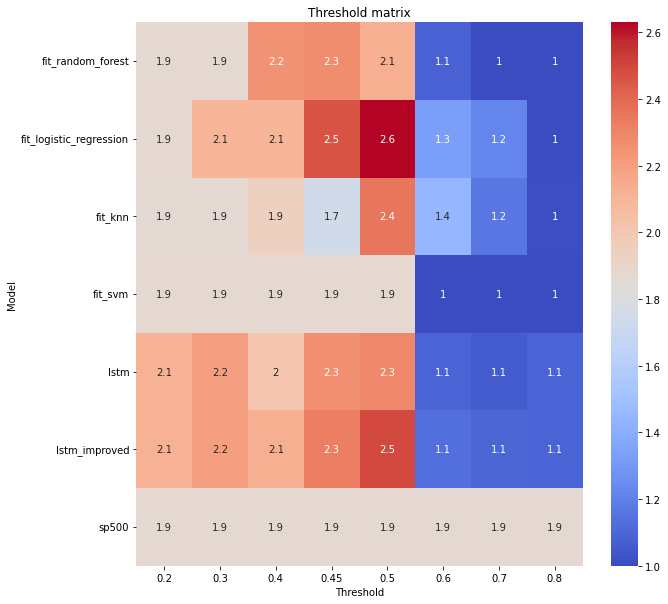

The code took 90.33162 seconds to run.


In [121]:
matrix_currencies_threshold_D1B_D2B_D3B = treshold_matrix(Features_currencies_D1B_D2b_D3B, Y_currencies, merged_df_currencies_2['2017-9-26':], 3, n_steps=1, n_estimators=200, max_depth=5, neighbors=30)

In [122]:
matrix_currencies_threshold_D1B_D2B_D3B

array([[1.87, 1.87, 2.25, 2.27, 2.13, 1.08, 1.  , 1.  ],
       [1.87, 2.1 , 2.1 , 2.46, 2.63, 1.33, 1.22, 1.  ],
       [1.86, 1.86, 1.94, 1.74, 2.35, 1.45, 1.16, 1.01],
       [1.87, 1.87, 1.87, 1.87, 1.87, 1.  , 1.  , 1.  ],
       [2.12, 2.2 , 2.01, 2.26, 2.29, 1.09, 1.06, 1.09],
       [2.12, 2.2 , 2.13, 2.32, 2.49, 1.13, 1.1 , 1.09],
       [1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87]])

In [123]:
thresholds_currencies_D1B_D2B_D3B = [0.45, 0.5, 0.5, 0.5, 0.5, 0.5]

Optimization terminated successfully.
         Current function value: 0.687045
         Iterations 4
14/14 [==============================] - 0s 4ms/step


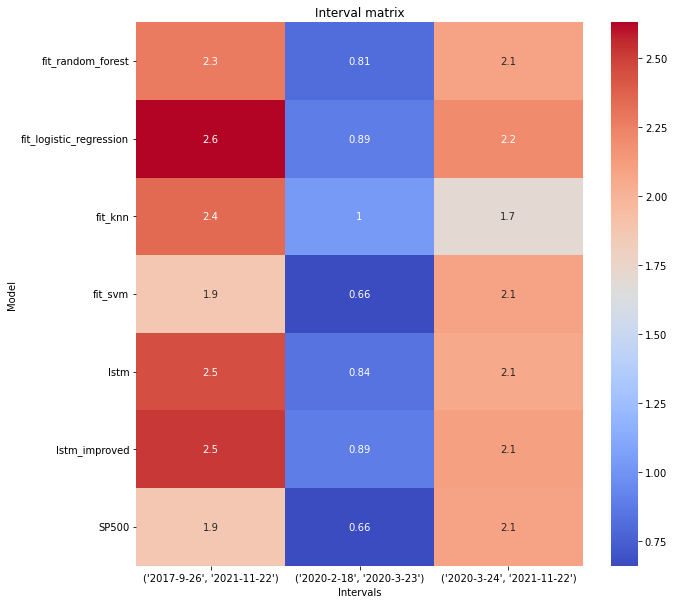

The code took 168.03514 seconds to run.


In [124]:
matrix_currencies_interval_D1B_D2B_D3B = interval_matrix(Features_currencies_D1B_D2b_D3B, Y_currencies, interval1, interval2, interval3, merged_df_currencies_2['2017-9-25':], 3, thresholds_currencies_D1B_D2B_D3B, neighbors=30, n_estimators=200, max_depth=5)

In [125]:
matrix_currencies_interval_D1B_D2B_D3B

array([[2.27, 0.81, 2.09],
       [2.63, 0.89, 2.2 ],
       [2.35, 1.03, 1.7 ],
       [1.87, 0.66, 2.09],
       [2.45, 0.84, 2.06],
       [2.52, 0.89, 2.1 ],
       [1.87, 0.66, 2.09]])

In [126]:
# Calculating the difference in NORD between interval matrices to identify which algorithms on 
# specific intervals have shown improvement.
print(matrix_currencies_interval_D1B_D2B_D3B - matrix_currencies_interval)

[[ 0.52  0.13  0.22]
 [-0.32  0.   -0.19]
 [ 0.02  0.18 -0.4 ]
 [ 0.    0.    0.  ]
 [ 0.49  0.13 -0.01]
 [ 0.42  0.14  0.03]
 [ 0.    0.    0.  ]]


Summary:

Algorithms are trained on the interval from 3.12.2003, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, and trained on the interval from 30.1.2001, until 25.9.2017, is 2.63.

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

Methodology A identifies features EURchange, GBPchange, JPYchange, CNYchange as important.

Methodology B identifies features JPYchange, CNYchange as important.

Upon applying common sense, we decide to include features JPYchange, CNYchange, GBPchange to our model.

Our feature vector changes to: X=[Day_1_before, Day_2_before, Day_3_before, JPYchange, CNYchange, GBPchange].

## <font color='orange'>Indices</font>

In [127]:
# Downloading data from other indices
merged_df_indices = merged_df_currencies.copy()

indices = [
    '^IXIC',   # NASDAQ Composite
    '^DJI',    # Dow Jones Industrial Average
    '^N225',   # Nikkei 225
    '^HSI',    # Hang Seng Index
    '^FTSE',   # FTSE 100
    '^GDAXI',  # DAX
    '^FCHI',   # CAC 40
]

for i in range(len(indices)):
    data = yf.download(indices[i], start='2003-12-3', end='2024-1-24')['Close']
    data_df = data.to_frame('Close' + indices[i])
    data_df.index = data_df.index.strftime('%Y-%m-%d')
    merged_df_indices.index = pd.to_datetime(merged_df_indices.index).tz_localize(None)
    data_df.index = pd.to_datetime(data_df.index).tz_localize(None)
    merged_df_indices = merged_df_indices.groupby(level=0).first()
    data_df = data_df.groupby(level=0).first()
    merged_df_indices = pd.merge(merged_df_indices, data_df, left_index=True, right_index=True, how='outer')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [128]:
merged_df_indices

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,ZARchange,BRLDay before,BRLchange,Close^IXIC,Close^DJI,Close^N225,Close^HSI,Close^FTSE,Close^GDAXI,Close^FCHI
2003-12-03,1066.619995,1074.300049,1064.630005,1064.729980,1064.729980,1441.70,1066.619995,-0.177197,0.0,-0.327066,...,0.404667,0.158854,0.749786,1960.250000,9873.419922,10326.389648,12361.179688,4392.000000,3875.659912,3501.929932
2003-12-04,1064.729980,1070.369995,1063.150024,1069.719971,1069.719971,1463.10,1064.729980,0.468663,1.0,-0.177197,...,0.397041,0.161488,1.658488,1968.800049,9930.820312,10429.990234,12342.650391,4378.200195,3874.780029,3496.550049
2003-12-05,1069.719971,1069.719971,1060.089966,1061.500000,1061.500000,1265.90,1069.719971,-0.768423,0.0,0.468663,...,0.027717,0.157851,-2.252536,1937.819946,9862.679688,10373.459961,12314.730469,4367.000000,3841.729980,3457.139893
2003-12-08,1061.500000,1069.589966,1060.930054,1069.300049,1069.300049,1218.90,1061.500000,0.734814,1.0,-0.768423,...,0.603967,0.160769,1.848850,1948.849976,9965.269531,10045.339844,12177.440430,4359.799805,3806.540039,3434.909912
2003-12-09,1069.300049,1071.939941,1059.160034,1060.180054,1060.180054,1465.50,1069.300049,-0.852894,0.0,0.734814,...,0.195517,0.155732,-3.133321,1908.319946,9923.419922,10124.280273,12393.639648,4379.600098,3846.179932,3456.120117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928.60,4765.979980,-0.561690,0.0,-0.373134,...,-0.513058,0.053622,-0.021449,14855.620117,37266.671875,35477.750000,15276.900391,7446.299805,16431.689453,7318.689941
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019.00,4739.209961,0.880526,1.0,-0.561690,...,-0.986098,0.052745,-1.635047,15055.650391,37468.609375,35466.171875,15391.790039,7459.100098,16567.349609,7401.350098
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287.20,4780.939941,1.231350,1.0,0.880526,...,-0.588721,0.052413,-0.629537,15310.969727,37863.800781,35963.269531,15308.690430,7461.899902,16555.130859,7371.640137
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297.61,4839.810059,0.219433,1.0,1.231350,...,-0.006752,0.052851,0.835571,15360.290039,38001.808594,36546.949219,14961.179688,7487.700195,16683.359375,7413.250000


In [129]:
# Calculating percentage change in index one day ago
indeces = ['Close^IXIC', 'Close^DJI', 'Close^N225', 'Close^HSI', 'Close^FTSE',
       'Close^GDAXI', 'Close^FCHI']
for index in indeces:
    merged_df_indices[index + str('Day before')] = merged_df_indices[index].shift(1)
    merged_df_indices[index + str('change')] = (((merged_df_indices[index] - merged_df_indices[index + str('Day before')]) / merged_df_indices[index + str('Day before')])*100).shift(1)

In [130]:
merged_df_indices

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,Close^N225Day before,Close^N225change,Close^HSIDay before,Close^HSIchange,Close^FTSEDay before,Close^FTSEchange,Close^GDAXIDay before,Close^GDAXIchange,Close^FCHIDay before,Close^FCHIchange
2003-12-03,1066.619995,1074.300049,1064.630005,1064.729980,1064.729980,1441.70,1066.619995,-0.177197,0.0,-0.327066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,1064.729980,1070.369995,1063.150024,1069.719971,1069.719971,1463.10,1064.729980,0.468663,1.0,-0.177197,...,10326.389648,NaN,12361.179688,NaN,4392.000000,NaN,3875.659912,NaN,3501.929932,NaN
2003-12-05,1069.719971,1069.719971,1060.089966,1061.500000,1061.500000,1265.90,1069.719971,-0.768423,0.0,0.468663,...,10429.990234,1.003260,12342.650391,-0.149899,4378.200195,-0.314203,3874.780029,-0.022703,3496.550049,-0.153626
2003-12-08,1061.500000,1069.589966,1060.930054,1069.300049,1069.300049,1218.90,1061.500000,0.734814,1.0,-0.768423,...,10373.459961,-0.541997,12314.730469,-0.226207,4367.000000,-0.255817,3841.729980,-0.852953,3457.139893,-1.127115
2003-12-09,1069.300049,1071.939941,1059.160034,1060.180054,1060.180054,1465.50,1069.300049,-0.852894,0.0,0.734814,...,10045.339844,-3.163073,12177.440430,-1.114844,4359.799805,-0.164877,3806.540039,-0.915992,3434.909912,-0.643017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928.60,4765.979980,-0.561690,0.0,-0.373134,...,35619.179688,-0.787174,15865.919922,-2.160847,7558.299805,-0.481904,16571.679688,-0.304057,7398.000000,-0.184576
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019.00,4739.209961,0.880526,1.0,-0.561690,...,35477.750000,-0.397060,15276.900391,-3.712483,7446.299805,-1.481815,16431.689453,-0.844756,7318.689941,-1.072047
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287.20,4780.939941,1.231350,1.0,0.880526,...,35466.171875,-0.032635,15391.790039,0.752048,7459.100098,0.171901,16567.349609,0.825601,7401.350098,1.129439
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297.61,4839.810059,0.219433,1.0,1.231350,...,35963.269531,1.401611,15308.690430,-0.539896,7461.899902,0.037535,16555.130859,-0.073752,7371.640137,-0.401413


In [131]:
# Filling up the NaNs
merged_df_indices = merged_df_indices.fillna(method='ffill')
merged_df_indices = merged_df_indices.fillna(method='bfill')
merged_df_indices_2 = merged_df_indices['2003-12-3':'2021-11-22']
merged_df_indices_2.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
                        ..
Close^FTSEchange         0
Close^GDAXIDay before    0
Close^GDAXIchange        0
Close^FCHIDay before     0
Close^FCHIchange         0
Length: 80, dtype: int64

In [132]:
# Initial NORD_max
features_NORD_max_indices = [['Day_1_before', 'Day_2_before', 'Day_3_before',  'JPYchange', 'CNYchange', 'GBPchange']]
result_NORD_max_indices = best_features(features_NORD_max_indices, merged_df_indices_2)
result_NORD_max_indices

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange']",2.954337


In [133]:
# Using methodology A for feature selection.
features_indices = ['Close^IXICchange', 'Close^DJIchange', 'Close^HSIchange', 'Close^FTSEchange',
                    'Close^GDAXIchange', 'Close^FCHIchange']
fixed_features = ['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange']
result_indices = methodology_A(fixed_features, features_indices, merged_df_indices_2, 2.954338)
result_indices

,Features,NORD
0,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^IXICchange']",2.388382
1,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^DJIchange']",2.874253
2,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^HSIchange']",2.954337
3,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^FTSEchange']",2.482739
4,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^GDAXIchange']",2.674017
5,"['Day_1_before', 'Day_2_before', 'Day_3_before', 'JPYchange', 'CNYchange', 'GBPchange', 'Close^FCHIchange']",2.746073


Methodologies A and B do not deem any of the new features important.

Summary:

Algorithms are trained on the interval from 3.12.2003, until 25.9.2017.

The NORD value on the validation set of a model using Logistic Regression as the algorithm, with features Day_1_before, Day_2_before, and Day_3_before, JPYchange, CNYchange, GBPchange and trained on the interval from 30.1.2001, until 25.9.2017, is 2.95

The NORD - BUY AND HOLD on the validation set is equal to 1.88.

Methodologies A and B do not deem any of the new features important.

Upon applying common sense, we decide to not include any of the new features to our model.

Our feature vector does not change and remains the same: X=[Day_1_before, Day_2_before, Day_3_before, JPYchange, CNYchange, GBPchange].

## <font color='orange'>Conclusion</font>

In [134]:
merged_df_indices

,Open,High,Low,Close,Adj Close,Volume,Close day before,pct_change,Direction,Day_1_before,...,Close^N225Day before,Close^N225change,Close^HSIDay before,Close^HSIchange,Close^FTSEDay before,Close^FTSEchange,Close^GDAXIDay before,Close^GDAXIchange,Close^FCHIDay before,Close^FCHIchange
2003-12-03,1066.619995,1074.300049,1064.630005,1064.729980,1064.729980,1441.70,1066.619995,-0.177197,0.0,-0.327066,...,10326.389648,1.003260,12361.179688,-0.149899,4392.000000,-0.314203,3875.659912,-0.022703,3501.929932,-0.153626
2003-12-04,1064.729980,1070.369995,1063.150024,1069.719971,1069.719971,1463.10,1064.729980,0.468663,1.0,-0.177197,...,10326.389648,1.003260,12361.179688,-0.149899,4392.000000,-0.314203,3875.659912,-0.022703,3501.929932,-0.153626
2003-12-05,1069.719971,1069.719971,1060.089966,1061.500000,1061.500000,1265.90,1069.719971,-0.768423,0.0,0.468663,...,10429.990234,1.003260,12342.650391,-0.149899,4378.200195,-0.314203,3874.780029,-0.022703,3496.550049,-0.153626
2003-12-08,1061.500000,1069.589966,1060.930054,1069.300049,1069.300049,1218.90,1061.500000,0.734814,1.0,-0.768423,...,10373.459961,-0.541997,12314.730469,-0.226207,4367.000000,-0.255817,3841.729980,-0.852953,3457.139893,-1.127115
2003-12-09,1069.300049,1071.939941,1059.160034,1060.180054,1060.180054,1465.50,1069.300049,-0.852894,0.0,0.734814,...,10045.339844,-3.163073,12177.440430,-1.114844,4359.799805,-0.164877,3806.540039,-0.915992,3434.909912,-0.643017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928.60,4765.979980,-0.561690,0.0,-0.373134,...,35619.179688,-0.787174,15865.919922,-2.160847,7558.299805,-0.481904,16571.679688,-0.304057,7398.000000,-0.184576
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019.00,4739.209961,0.880526,1.0,-0.561690,...,35477.750000,-0.397060,15276.900391,-3.712483,7446.299805,-1.481815,16431.689453,-0.844756,7318.689941,-1.072047
2024-01-19,4796.279785,4842.069824,4785.870117,4839.810059,4839.810059,4287.20,4780.939941,1.231350,1.0,0.880526,...,35466.171875,-0.032635,15391.790039,0.752048,7459.100098,0.171901,16567.349609,0.825601,7401.350098,1.129439
2024-01-22,4853.419922,4868.410156,4844.049805,4850.430176,4850.430176,4297.61,4839.810059,0.219433,1.0,1.231350,...,35963.269531,1.401611,15308.690430,-0.539896,7461.899902,0.037535,16555.130859,-0.073752,7371.640137,-0.401413


Optimization terminated successfully.
         Current function value: 0.684770
         Iterations 5


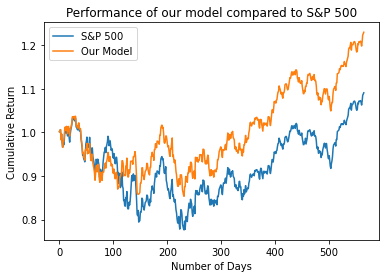

<Figure size 432x288 with 0 Axes>

In [135]:
# Authors model
Features_authors_model = merged_df_indices[['Day_1_before', 'Day_2_before', 'Day_3_before','JPYchange', 'CNYchange', 'GBPchange']]
Y = merged_df_indices[['Direction']]
accuracy_authors, y_test_authors, y_pred_class_authors, y_pred_prob_authors = fit_logistic_regression_test_data(Features_authors_model, Y, threshold = 0.5)
val_authors_model = investment_return( y_pred_class_authors.reshape(-1), merged_df_indices['2021-11-23':])["dollars"].iloc[-1]
plot_investment_performance( y_pred_class_authors.reshape(-1), merged_df_indices['2021-11-23':'2024-01-23'])
plt.savefig('investment_performance_plot_authors_model.svg', format='svg')

In [136]:
val_authors_model

1.2297666681535147

Optimization terminated successfully.
         Current function value: 0.684559
         Iterations 5


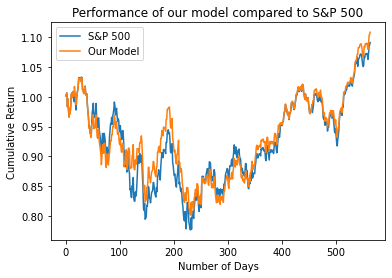

<Figure size 432x288 with 0 Axes>

In [137]:
# Methodology B
Features_methodology_b = merged_df_indices[['Day_1_before', 'Day_4_before', 'Day_5_before','JPYchange', 'CNYchange']]
Y = merged_df_indices[['Direction']]
accuracy_methodology_b, y_test_methodology_b, y_pred_class_methodology_b, y_pred_prob_methodology_b = fit_logistic_regression_test_data(Features_methodology_b, Y, threshold = 0.5)
val_methodology_b = investment_return( y_pred_class_methodology_b.reshape(-1), merged_df_indices['2021-11-23':])["dollars"].iloc[-1]
plot_investment_performance( y_pred_class_methodology_b.reshape(-1), merged_df_indices['2021-11-23':'2024-01-23'])
plt.savefig('investment_performance_plot_methodology_b.svg', format='svg')

In [138]:
val_methodology_b

1.1083267819658968

Optimization terminated successfully.
         Current function value: 0.684396
         Iterations 5


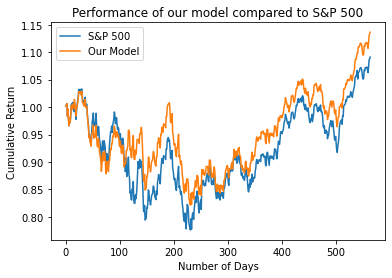

<Figure size 432x288 with 0 Axes>

In [139]:
# Methodology A
Features_methodology_a = merged_df_indices[['Day_1_before', 'Day_4_before', 'Day_5_before','EURchange','JPYchange', 'CNYchange', 'GBPchange']]
Y = merged_df_indices[['Direction']]
accuracy_methodology_a, y_test_methodology_a, y_pred_class_methodology_a, y_pred_prob_methodology_a = fit_logistic_regression_test_data(Features_methodology_a, Y, threshold = 0.5)
val_methodology_a = investment_return( y_pred_class_methodology_a.reshape(-1), merged_df_indices['2021-11-23':])["dollars"].iloc[-1]
plot_investment_performance( y_pred_class_methodology_a.reshape(-1), merged_df_indices['2021-11-23':'2024-01-23'])
plt.savefig('investment_performance_plot_methodology_a.svg', format='svg')

In [140]:
val_methodology_a

1.1362131458803497

Optimization terminated successfully.
         Current function value: 0.677693
         Iterations 5


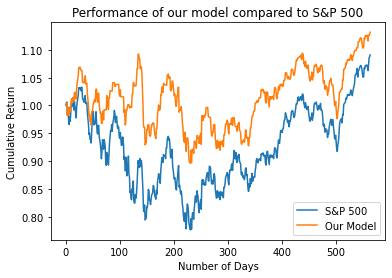

<Figure size 432x288 with 0 Axes>

In [141]:
# All Features
Features_all_features = merged_df_indices[['Volume', 'Day_1_before', 'Day_2_before', 'Day_3_before', 
'Day_4_before', 'Day_5_before', 'Day_6_before', 'Day_7_before', 'Day_8_before', 'Day_9_before', 
'Open_pct_change_Day_before', 'High_pct_change_Day_before','Low_pct_change_Day_before', 'Change_volume',
'VIX_change', 'EURchange', 'GBPchange', 'JPYchange', 'CHFchange', 'CNYchange', 'BRLchange', 'ZARchange',
'Close^IXICchange','Close^DJIchange','Close^N225change', 'Close^HSIchange','Close^FTSEchange', 
'Close^GDAXIchange', 'Close^FCHIchange']]
Y = merged_df_indices[['Direction']]
accuracy_all_features, y_test_all_features, y_pred_class_all_features, y_pred_prob_all_features = fit_logistic_regression_test_data(Features_all_features, Y, threshold = 0.5)
val_all_features = investment_return( y_pred_class_all_features.reshape(-1), merged_df_indices['2021-11-23':])["dollars"].iloc[-1]
plot_investment_performance( y_pred_class_all_features.reshape(-1), merged_df_indices['2021-11-23':'2024-01-23'])
plt.savefig('investment_performance_plot_all_features.svg', format='svg')

In [142]:
val_all_features

1.131649851439757